# Packages/ Imports

In [1]:
'''
Update conda env using the following line in the /environment directory
    ` conda env update --file ml_portfolio_opt_env_<OS>.yml --prune `
'''

'\nUpdate conda env using the following line in the /environment directory\n    ` conda env update --file ml_portfolio_opt_env_<OS>.yml --prune `\n'

In [2]:
import sys
import os
import warnings
warnings.filterwarnings(action='ignore')

import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import yfinance as yf
import statsmodels
import pyfolio as pf

# Import libraries for ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from src.myarima import MyARIMA
from src.init_dataset import InitDataset
from src.mykmeans import MyKMeans
import src.utils as utils
from src.mptoptimizer import MPTOptimizer

print("Finished importing utils!")

Finished importing utils!


# Data Management

In [3]:
#Since dataset has been created, init is set to false
InitDataset.create_econ_data(init=False)
InitDataset.create_merged_stock_data(init=False)
InitDataset.create_adj_closed_price(init=False)

## Data Exploration

In [4]:
# Load the dataset for the first ticker
dateparse = lambda dates: pd.to_datetime(dates, format='%Y-%m-%d')
stock_data = pd.read_csv(r'dataset/stock_data/AAPL_data.csv', parse_dates=['Date'], index_col='Date', date_parser=dateparse)
stock_data.head()

Open       High        Low      Close  Adj Close     Volume  \
Date                                                                           
2018-01-02  42.540001  43.075001  42.314999  43.064999  40.670986  102223600   
2018-01-03  43.132500  43.637501  42.990002  43.057499  40.663898  118071600   
2018-01-04  43.134998  43.367500  43.020000  43.257500  40.852768   89738400   
2018-01-05  43.360001  43.842499  43.262501  43.750000  41.317894   94640000   
2018-01-08  43.587502  43.902500  43.482498  43.587502  41.164425   82271200   

           ticker  
Date               
2018-01-02   AAPL  
2018-01-03   AAPL  
2018-01-04   AAPL  
2018-01-05   AAPL  
2018-01-08   AAPL

In [5]:
# Check the shape of the dataset
print(stock_data.shape)

# Check the start and end date of the dataset
print(stock_data.index.min())
print(stock_data.index.max())

# Duration of stock data
duration = stock_data.index.max() - stock_data.index.min()
print(duration)

(1509, 7)
2018-01-02 00:00:00
2023-12-29 00:00:00
2187 days 00:00:00


In [6]:
# Data Cleaning and Sanity Check
# Check for missing values
print(stock_data.isnull().sum(), '\n')
# Check for duplicate values
print(stock_data.duplicated().sum())
# Describe the dataset
print(stock_data.describe())

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
ticker       0
dtype: int64 

0
              Open         High          Low        Close    Adj Close  \
count  1509.000000  1509.000000  1509.000000  1509.000000  1509.000000   
mean    110.326080   111.583562   109.157902   110.428236   108.703985   
std      51.003328    51.520038    50.513390    51.043671    51.349589   
min      35.994999    36.430000    35.500000    35.547501    34.075390   
25%      54.105000    54.794998    53.290001    53.872501    51.655396   
50%     123.660004   124.980003   122.139999   123.540001   121.447418   
75%     152.570007   154.559998   150.800003   152.740005   151.446182   
max     198.020004   199.619995   197.000000   198.110001   197.857529   

             Volume  
count  1.509000e+03  
mean   1.073273e+08  
std    5.513331e+07  
min    2.404830e+07  
25%    7.078370e+07  
50%    9.296430e+07  
75%    1.280440e+08  
max    4.265100e+08  


# Initial Data Visualization

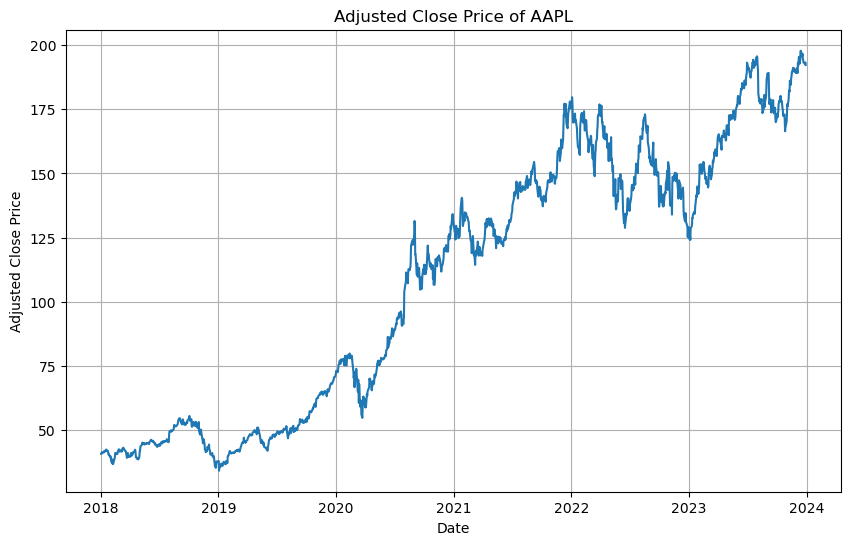

In [7]:
# Plot the adjusted close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.title('Adjusted Close Price of AAPL')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.plot(stock_data['Adj Close'])
plt.show()

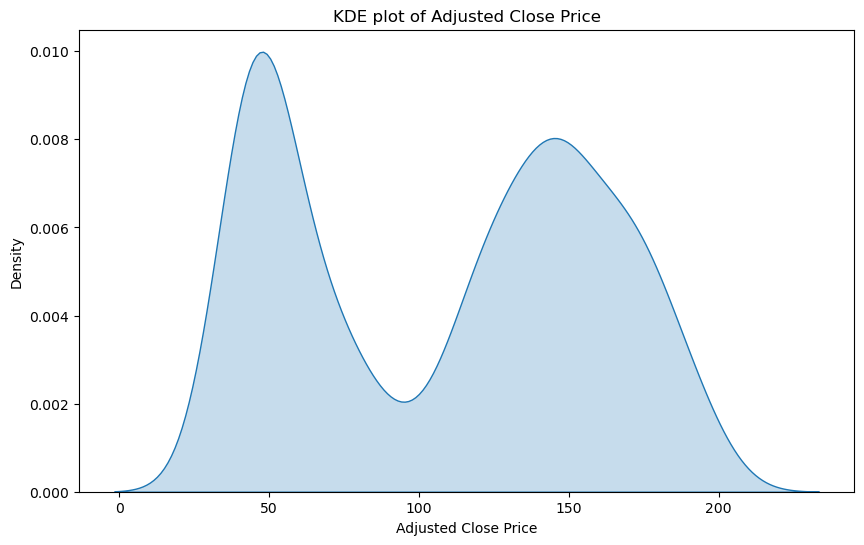

In [8]:
# KDE plot of the adjusted close price
plt.figure(figsize=(10,6))
sns.kdeplot(stock_data['Adj Close'], shade=True)
plt.title('KDE plot of Adjusted Close Price')
plt.xlabel('Adjusted Close Price')
plt.ylabel('Density')
plt.show()

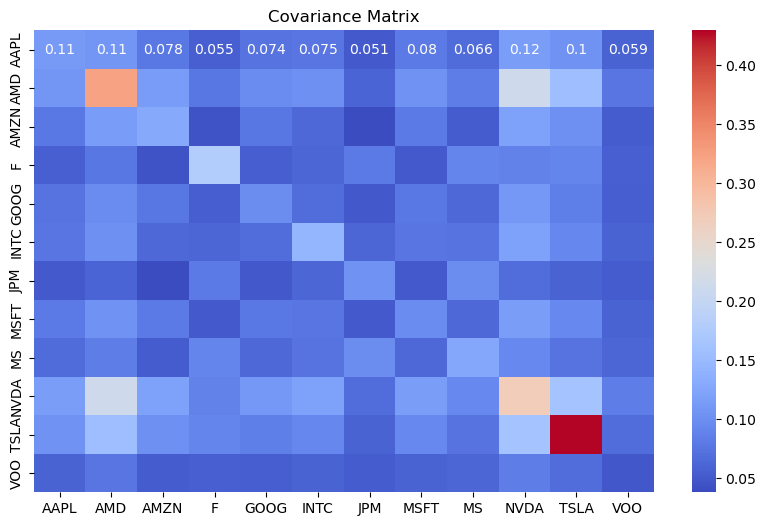

In [9]:
# Load the dataset
dateparse = lambda dates: pd.to_datetime(dates, format='%Y-%m-%d')
price_data = pd.read_csv(r'dataset/stock_data/combined_stock_adj_closed.csv', parse_dates=['Date'], index_col='Date', date_parser=dateparse)
train_data = price_data[price_data.index < '2023-01-01']
test_data = price_data[price_data.index >= '2023-01-01']
index_data = pd.read_csv(r'dataset/stock_data/SPY_data.csv', parse_dates=['Date'], index_col='Date', date_parser=dateparse)['Adj Close']
portfolio_returns = train_data.pct_change()
covariance = portfolio_returns.cov()*252
# Heatmap of the covariance matrix
plt.figure(figsize=(10,6))
sns.heatmap(covariance, annot=True, cmap='coolwarm')
plt.title('Covariance Matrix')
plt.show()

In [10]:
# Allocate equal weights to all stocks

weights = [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
portfolio_variance = np.transpose(weights) @ covariance @ weights
print(f'Portfolio Variance: {portfolio_variance}')

Portfolio Variance: 0.794052261265668


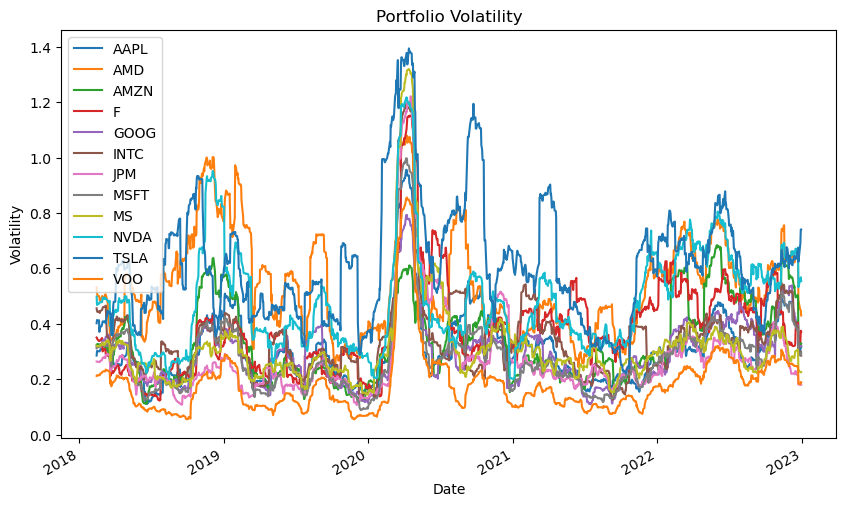

In [11]:
# Calculate the portfolio volatility

windowed = portfolio_returns.rolling(30)
volatility = windowed.std() * np.sqrt(252)
volatility.plot(figsize=(10,6))
plt.title('Portfolio Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.show()

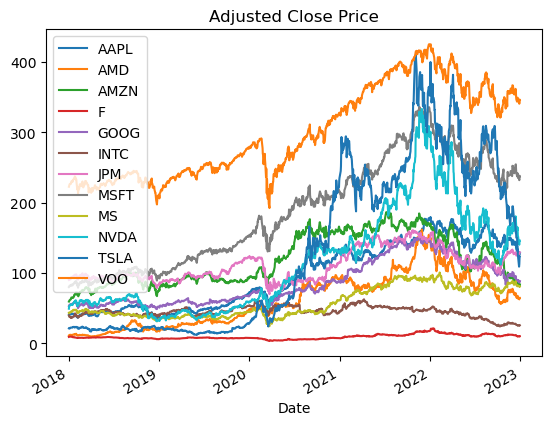

In [12]:
# Plot the adjusted close price
train_data.plot(title='Adjusted Close Price')
plt.show()

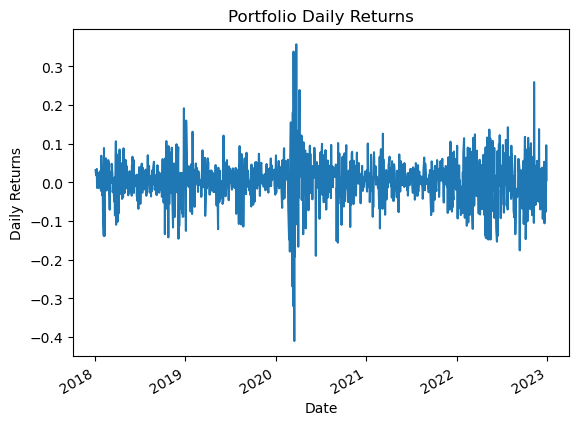

In [13]:
# Calculate the daily returns
asset_returns = train_data.pct_change()
portfolio_returns = asset_returns@weights

# Plot the daily returns
portfolio_returns.plot().set_ylabel('Daily Returns')
plt.title('Portfolio Daily Returns')
plt.show()

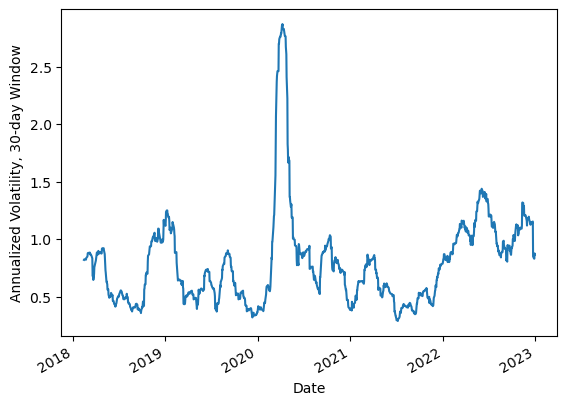

In [14]:
# Calculate the 30-day rolling window of portfolio returns
returns_windowed= portfolio_returns.rolling(30)

# Compute the annualized volatility series
volatility_series = returns_windowed.std()*np.sqrt(252)

# Plot the portfolio volatility
volatility_series.plot().set_ylabel("Annualized Volatility, 30-day Window")
plt.show()

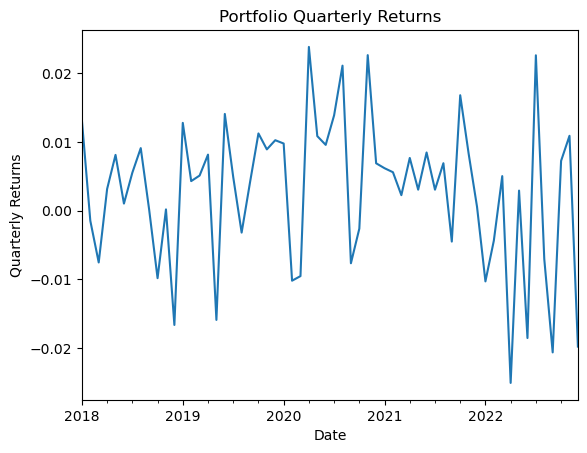

In [15]:
# Convert daily returns to quarterly average returns
quarterly_returns = portfolio_returns.resample('MS').mean().dropna()
quarterly_returns.plot().set_ylabel("Quarterly Returns")
plt.title('Portfolio Quarterly Returns')
plt.show()

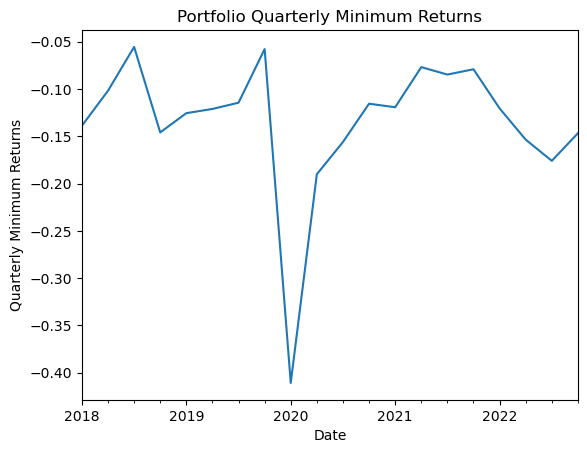

In [16]:
# Transform daily portfolio_returns returns into quarterly minimum returns
quarterly_min_returns = portfolio_returns.resample('Q').min().dropna()
quarterly_min_returns.plot().set_ylabel("Quarterly Minimum Returns")
plt.title('Portfolio Quarterly Minimum Returns')
plt.show()

## Kmeans - Volatility (Daily)

Suggested Stocks without PCA for k=3: ['JPM', 'NVDA', 'VOO']


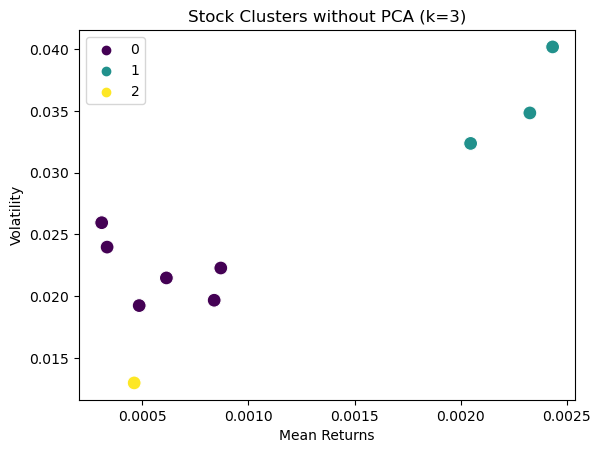

Suggested Stocks without PCA for k=4: ['INTC', 'NVDA', 'JPM', 'VOO']


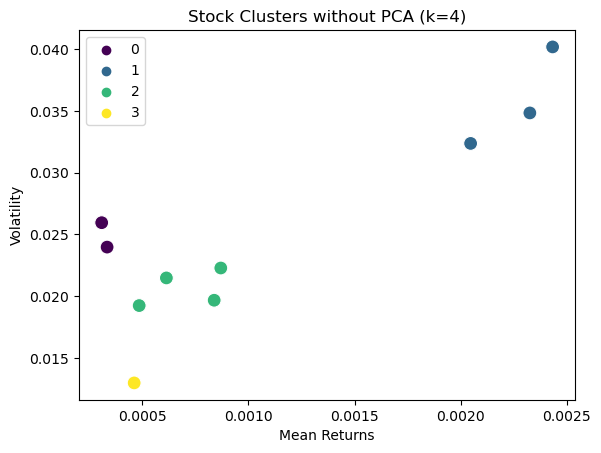

Suggested Stocks without PCA for k=5: ['INTC', 'NVDA', 'JPM', 'VOO', 'TSLA']


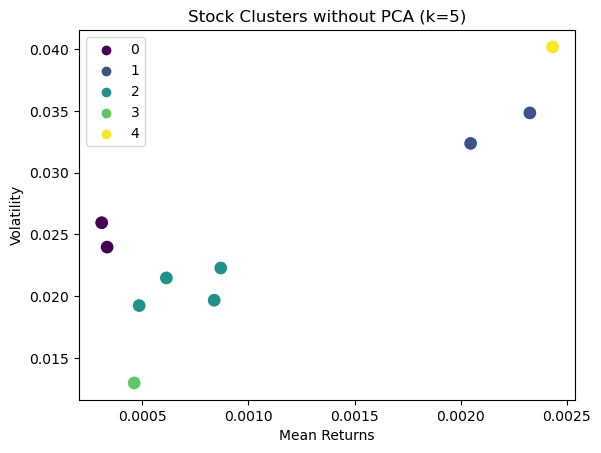

Suggested Stocks without PCA for k=6: ['NVDA', 'JPM', 'TSLA', 'VOO', 'INTC', 'GOOG']


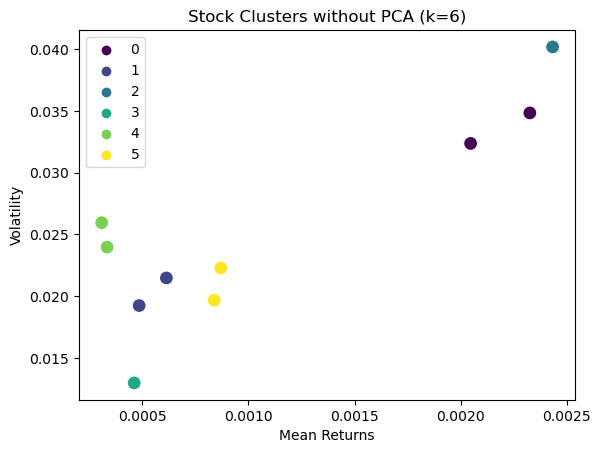

Suggested Stocks without PCA for k=7: ['GOOG', 'NVDA', 'TSLA', 'INTC', 'VOO', 'JPM', 'AMD']


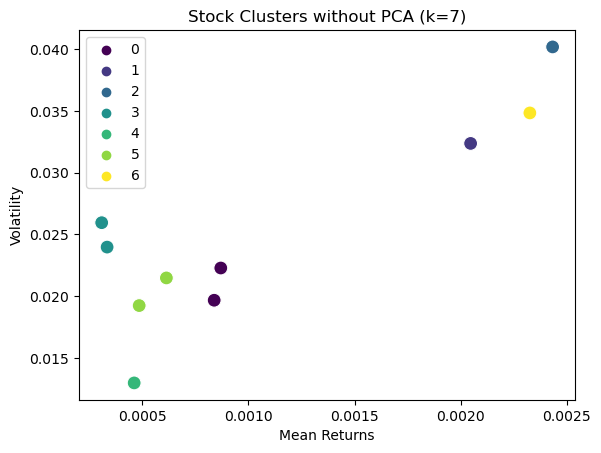

Suggested Stocks without PCA for k=8: ['INTC', 'AMD', 'JPM', 'VOO', 'GOOG', 'TSLA', 'NVDA', 'AMZN']


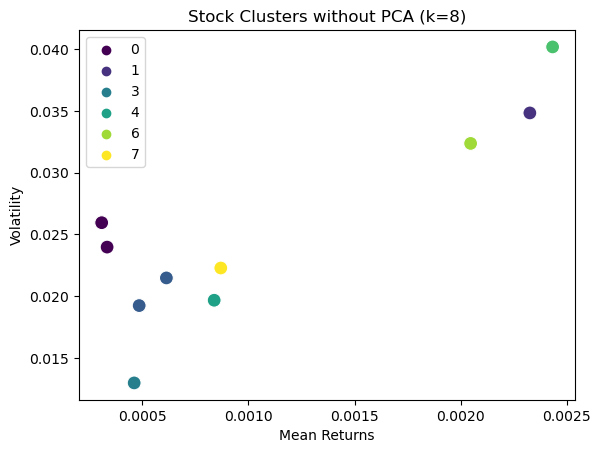

Suggested Stocks without PCA for k=9: ['INTC', 'AMD', 'JPM', 'VOO', 'GOOG', 'TSLA', 'NVDA', 'AMZN', 'MS']


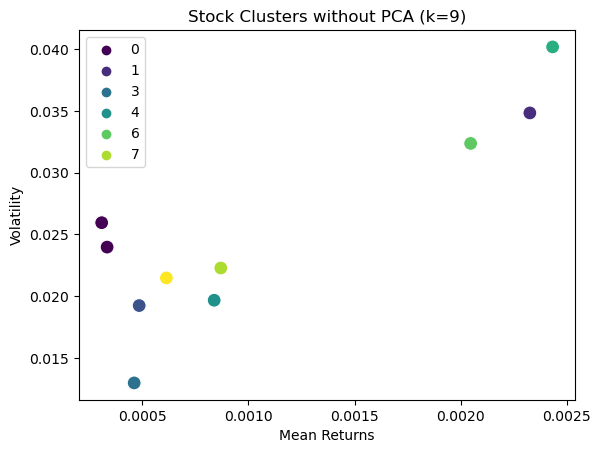

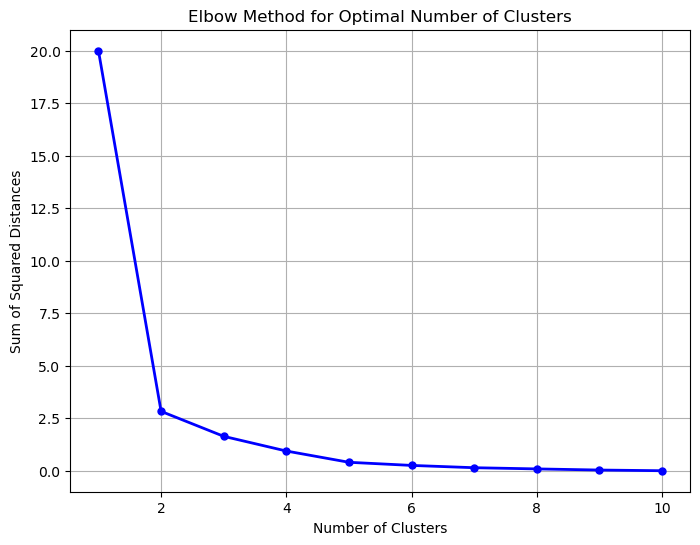

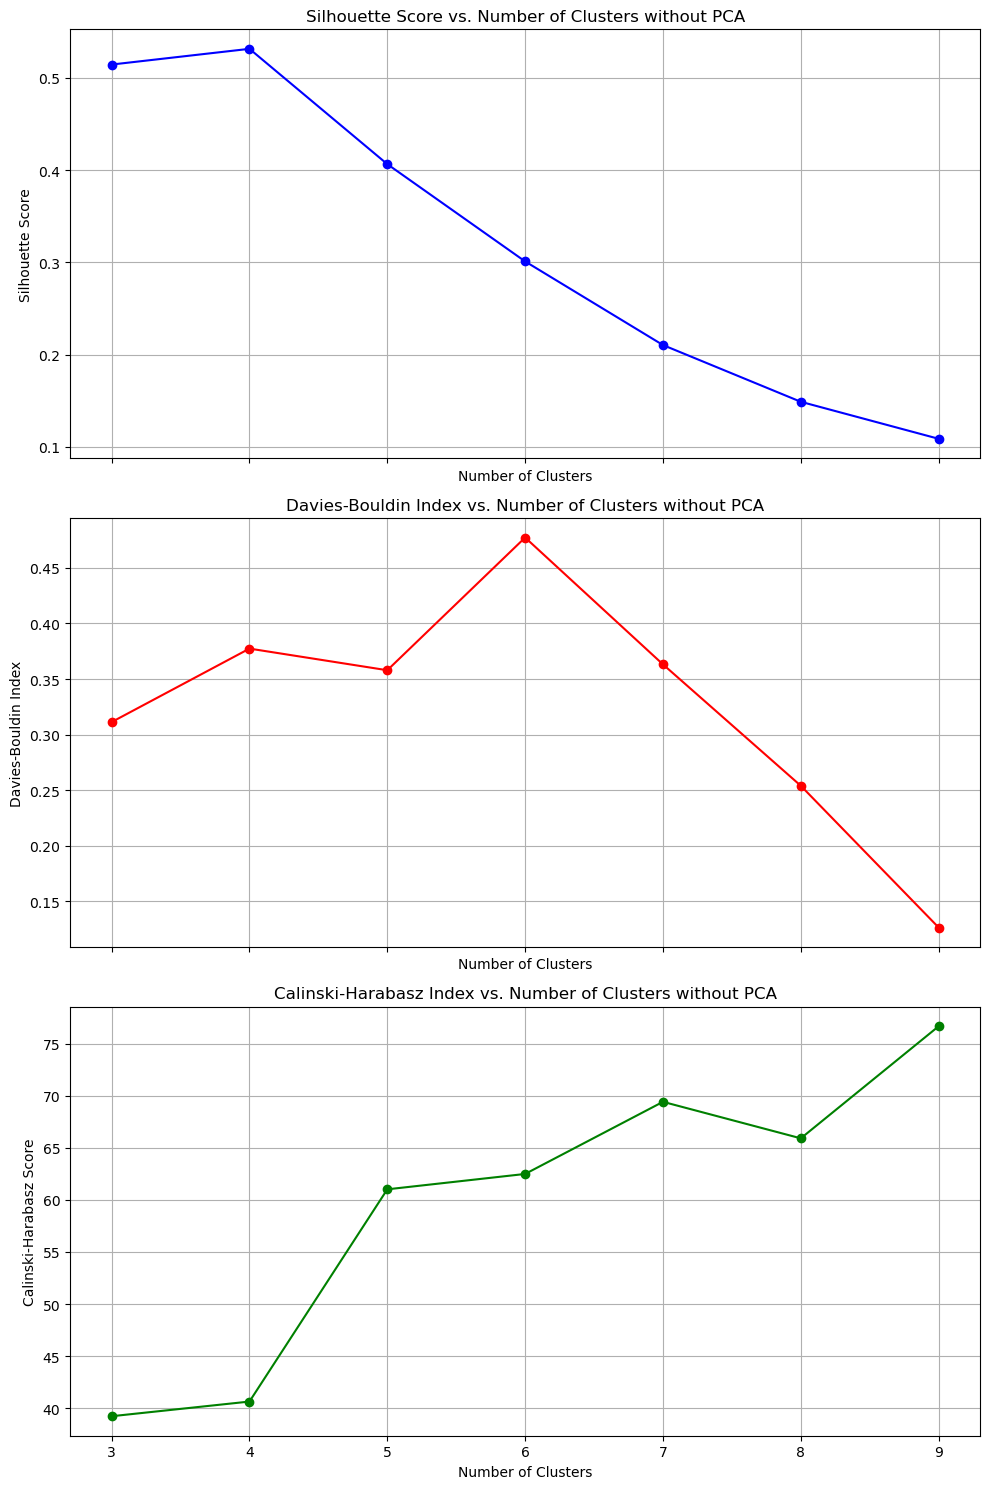


Clustering with PCA
Suggested Stocks with PCA for k=3: ['VOO', 'NVDA', 'TSLA']


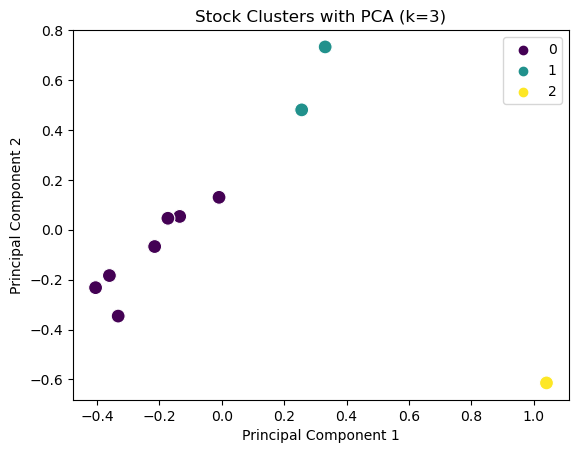

Suggested Stocks with PCA for k=4: ['JPM', 'NVDA', 'TSLA', 'VOO']


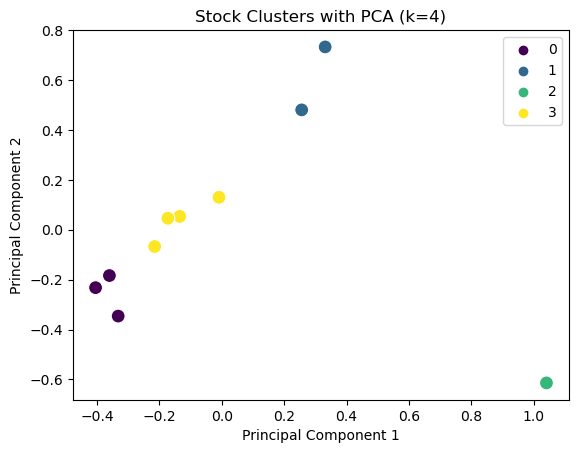

Suggested Stocks with PCA for k=5: ['AMD', 'VOO', 'TSLA', 'JPM', 'NVDA']


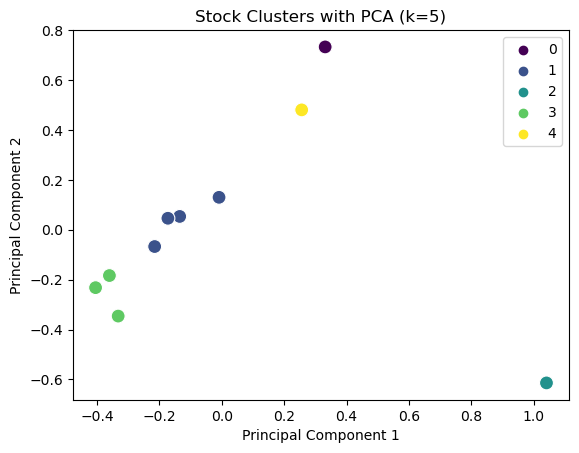

Suggested Stocks with PCA for k=6: ['NVDA', 'JPM', 'TSLA', 'AMZN', 'AMD', 'VOO']


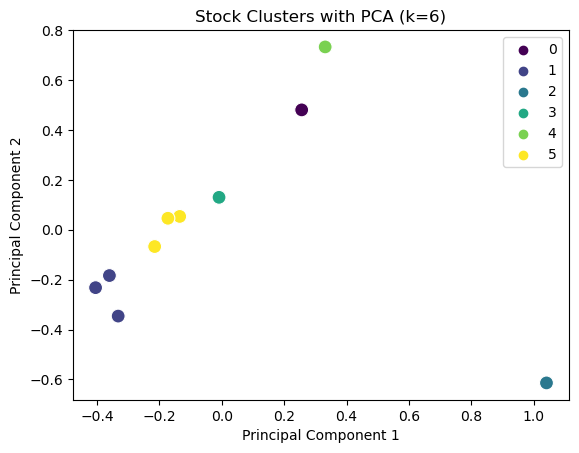

Suggested Stocks with PCA for k=7: ['VOO', 'TSLA', 'NVDA', 'JPM', 'AMD', 'AMZN', 'F']


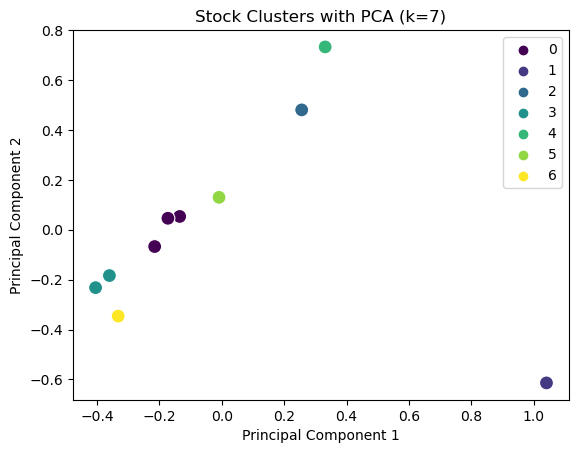

Suggested Stocks with PCA for k=8: ['F', 'NVDA', 'TSLA', 'GOOG', 'AMD', 'JPM', 'VOO', 'AMZN']


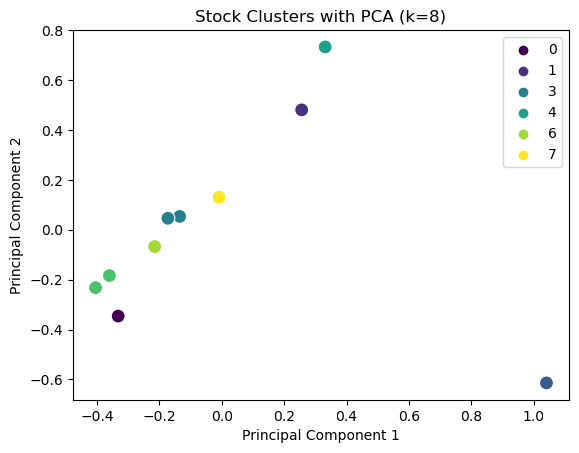

Suggested Stocks with PCA for k=9: ['F', 'NVDA', 'TSLA', 'GOOG', 'AMD', 'MS', 'VOO', 'AMZN', 'JPM']


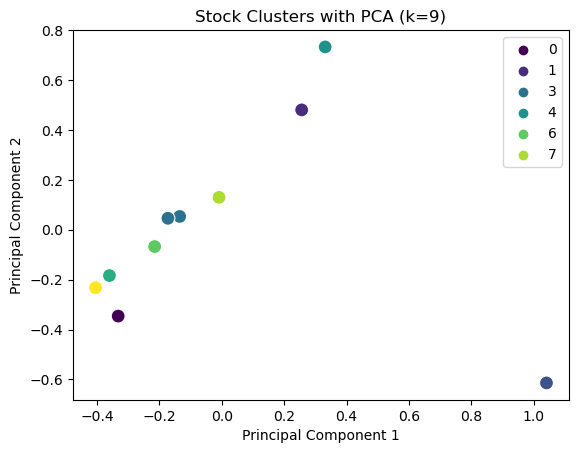

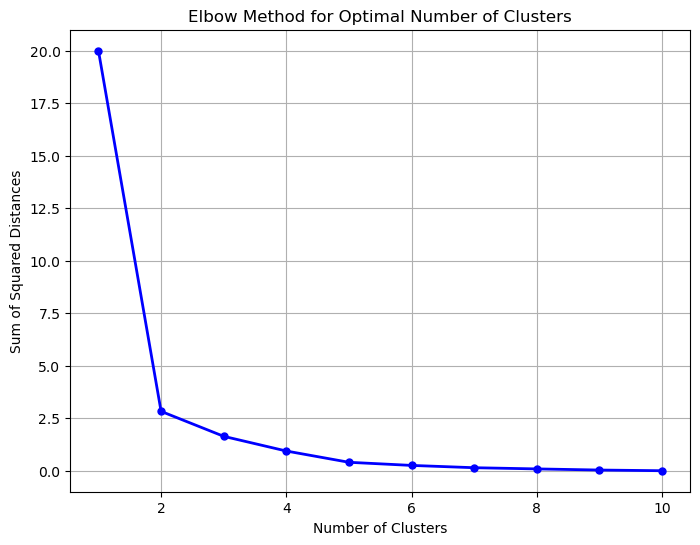

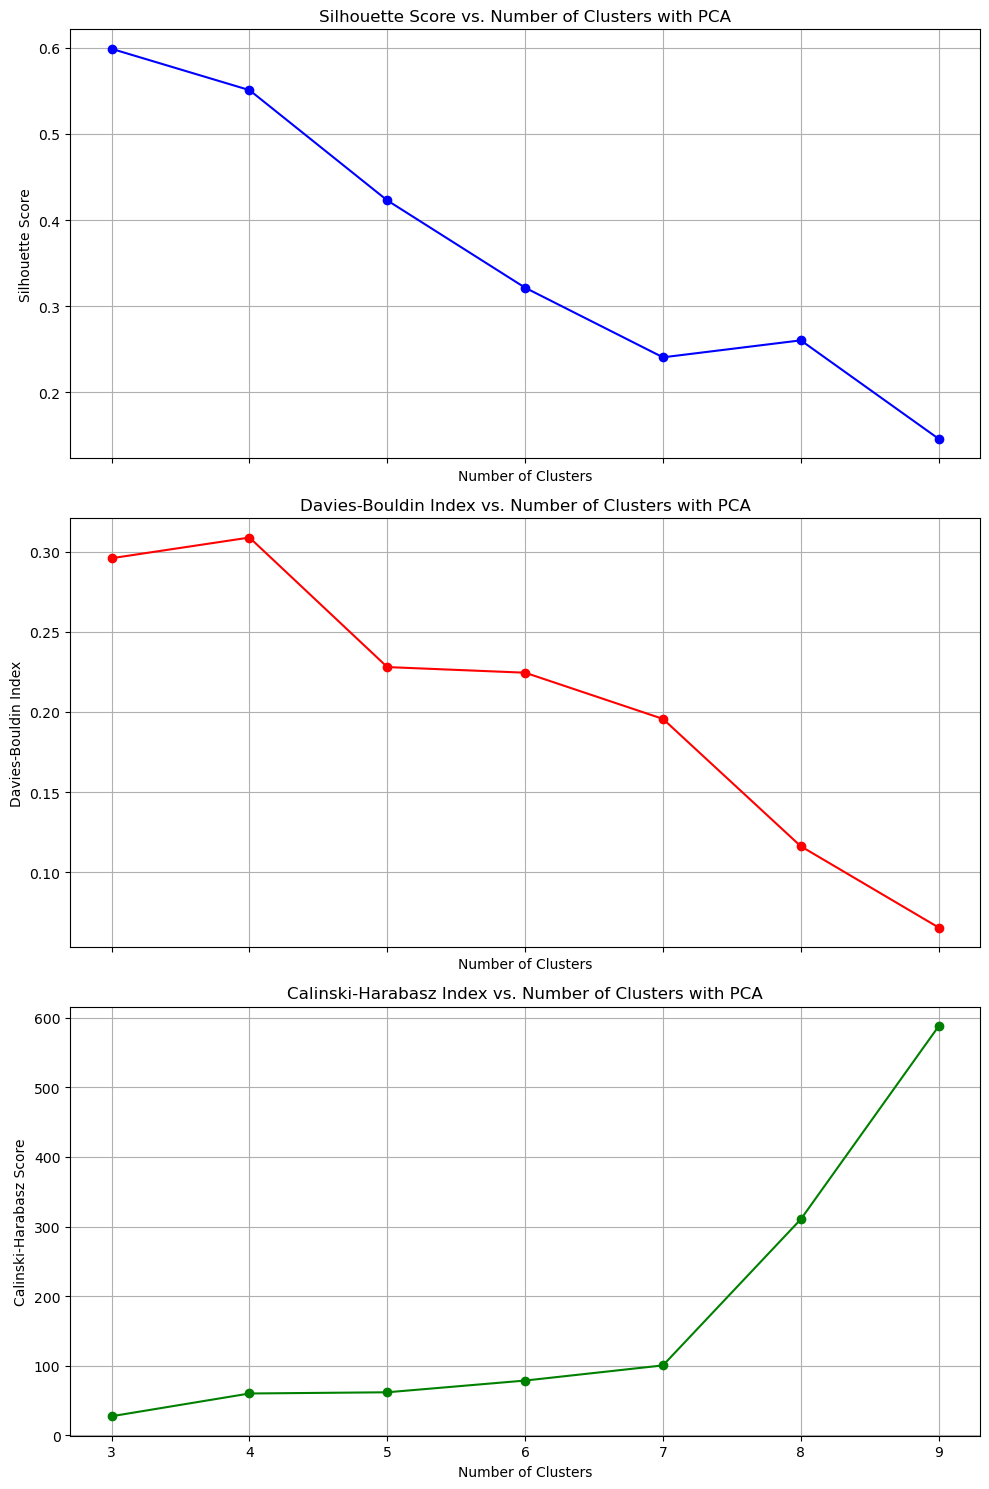

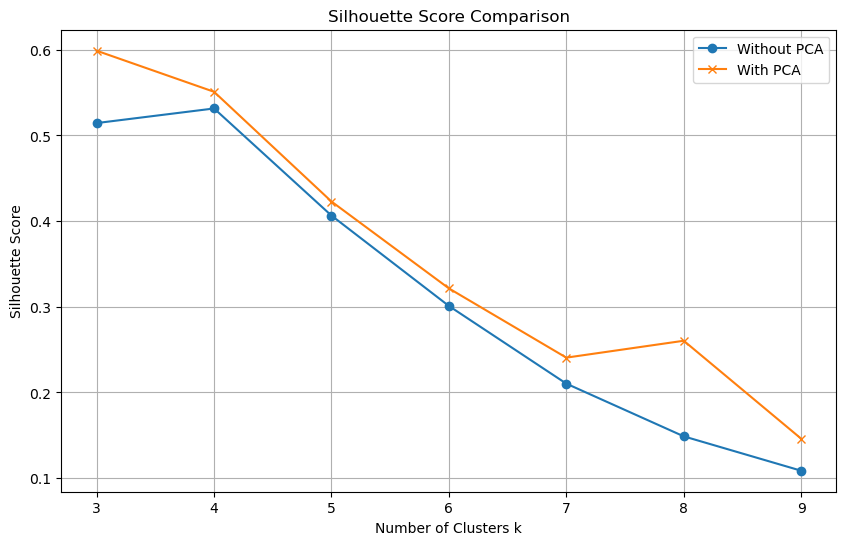

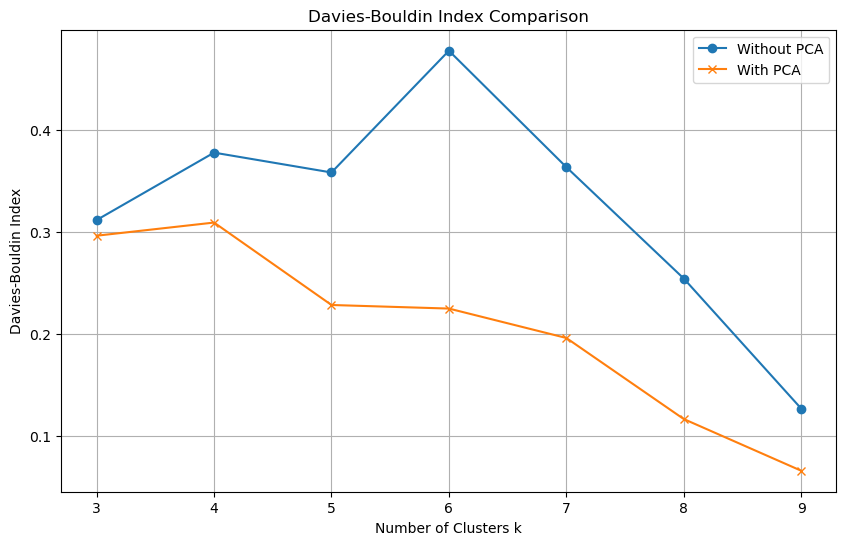

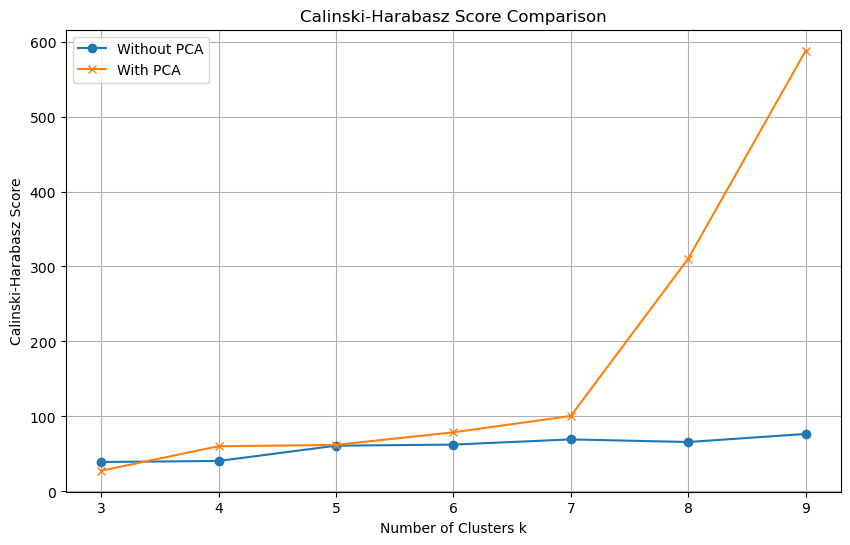

In [17]:
from src.mykmeans import MyKMeans

kmeans = MyKMeans()
kmeans.set_stock_data()
kmeans.volatility_feature_engineering()

cluster_range = range(3, 10)
kmeans.volatility_clustering_without_pca(range_n_clusters=cluster_range)
kmeans.plot_elbow_method()
kmeans.plot_metrics_without_pca()
kmeans.volatility_clustering_with_pca(range_n_clusters=cluster_range)
kmeans.plot_elbow_method()
kmeans.plot_metrics_pca()

kmeans.plot_metrics()

## Kmeans - Quarterly data


Without PCA - n_clusters=4, Silhouette Score: 0.40, Davies-Bouldin Index: 0.77, Calinski-Harabasz Index: 21.78


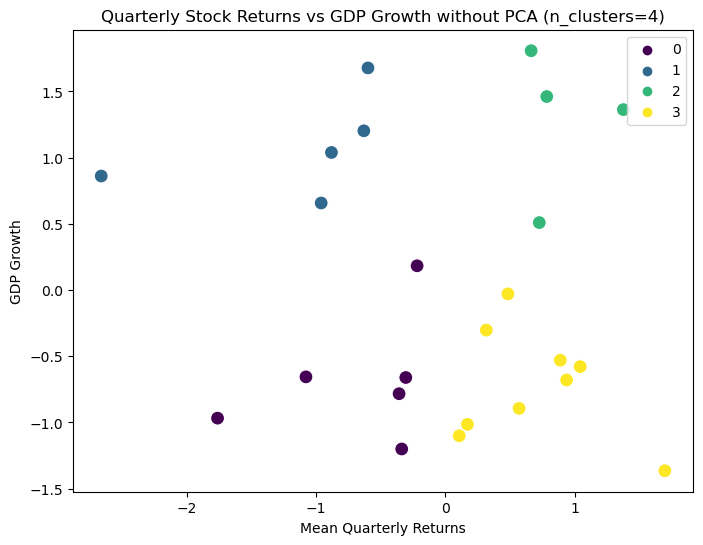

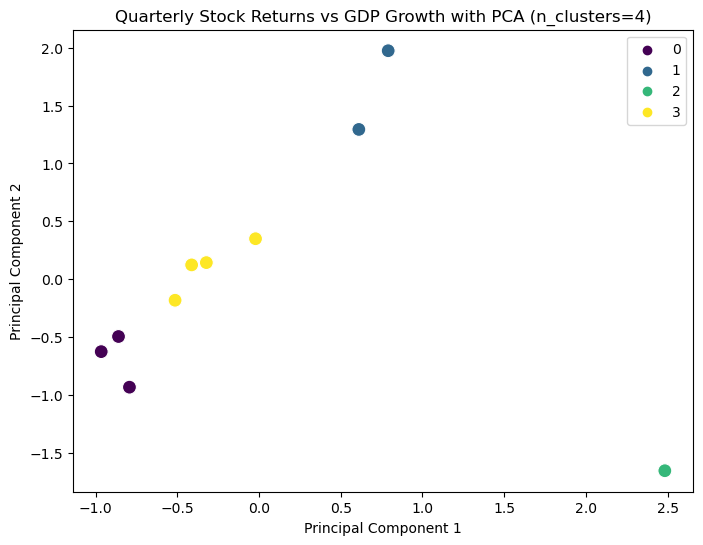

With PCA - n_clusters=4, Silhouette Score: 0.55, Davies-Bouldin Index: 0.31, Calinski-Harabasz Index: 60.28


In [18]:
from src.mykmeans import MyKMeans

kmeans = MyKMeans()
kmeans.set_stock_data()
kmeans.gdp_quarterly_feature_engineering()

kmeans.gdp_quarterly_clustering_without_pca()
kmeans.gdp_quarterly_clustering_pca()


## Kmeans - Economic data 

Without PCA - REAINTRATREARAT10Y: n_clusters=4, Silhouette Score: 0.40, Davies-Bouldin Index: 0.81, Calinski-Harabasz Index: 60.05


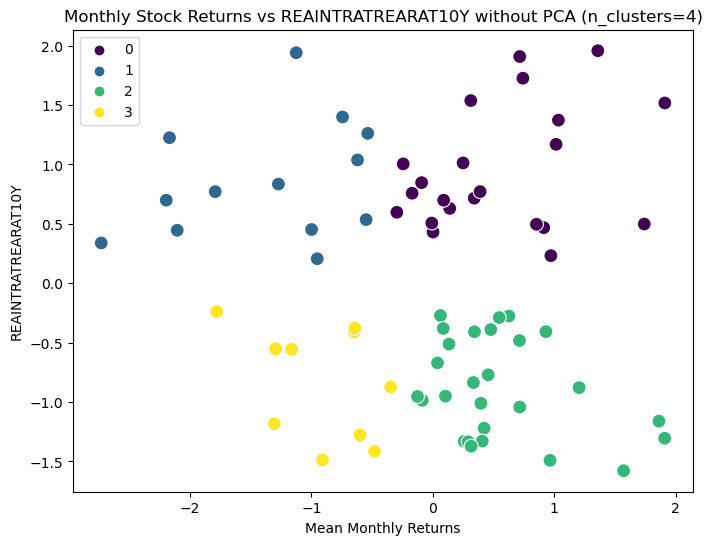

Without PCA - MEDCPIM158SFRBCLE: n_clusters=4, Silhouette Score: 0.40, Davies-Bouldin Index: 0.85, Calinski-Harabasz Index: 59.42


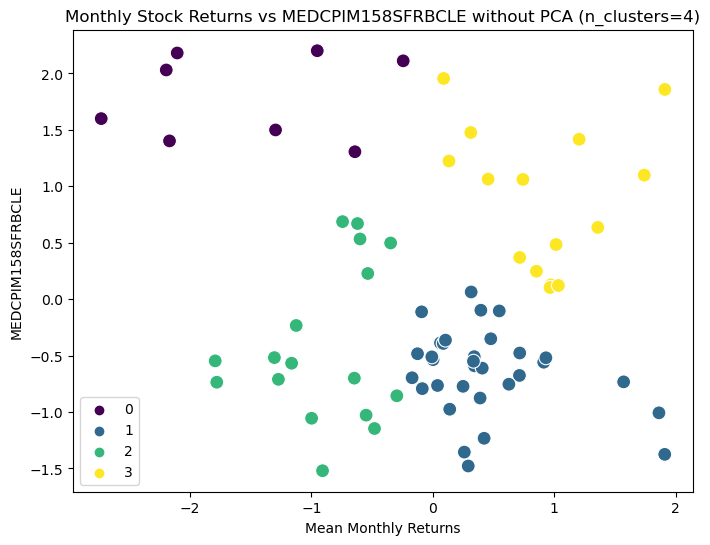

Without PCA - PSAVERT: n_clusters=4, Silhouette Score: 0.35, Davies-Bouldin Index: 0.84, Calinski-Harabasz Index: 63.66


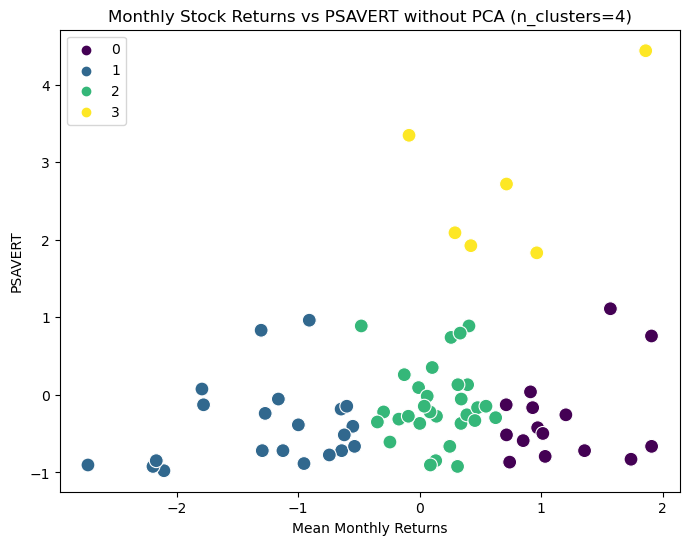

Without PCA - UNRATE: n_clusters=4, Silhouette Score: 0.48, Davies-Bouldin Index: 0.73, Calinski-Harabasz Index: 78.83


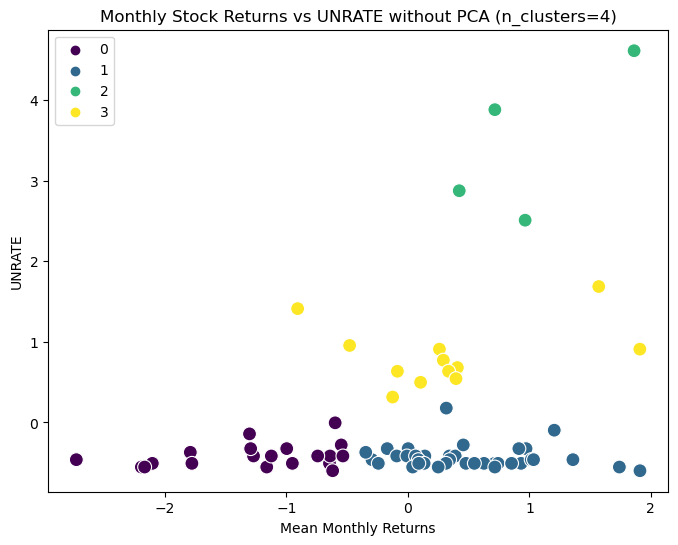

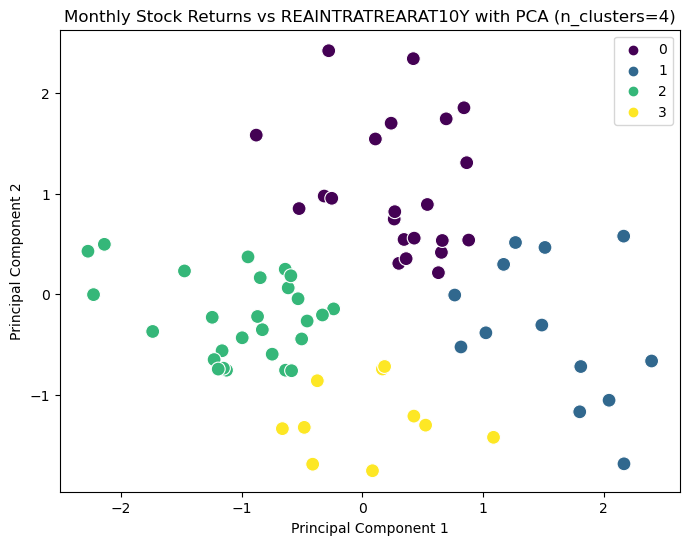

With PCA - REAINTRATREARAT10Y: n_clusters=4, Silhouette Score: 0.40, Davies-Bouldin Index: 0.81, Calinski-Harabasz Index: 60.05


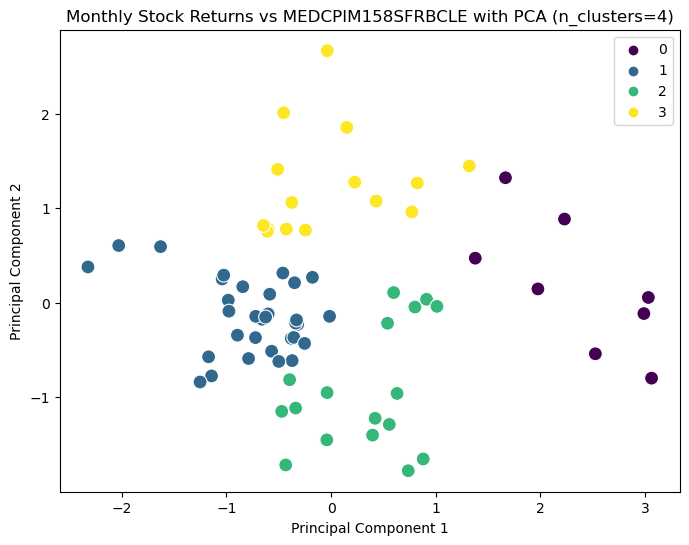

With PCA - MEDCPIM158SFRBCLE: n_clusters=4, Silhouette Score: 0.40, Davies-Bouldin Index: 0.85, Calinski-Harabasz Index: 59.42


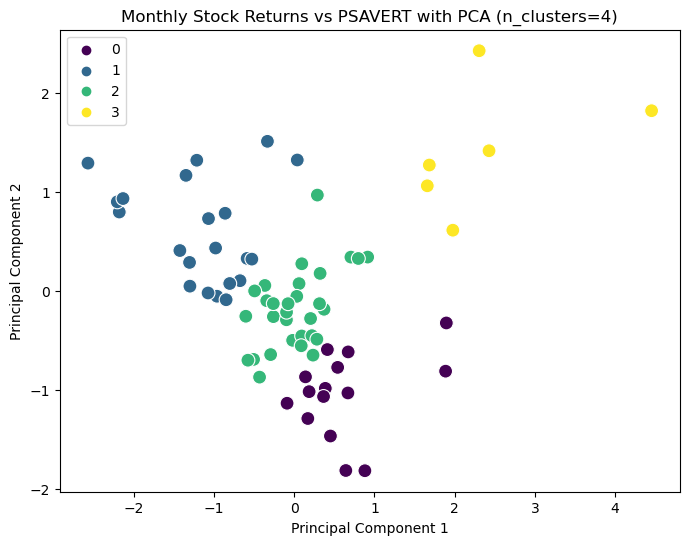

With PCA - PSAVERT: n_clusters=4, Silhouette Score: 0.35, Davies-Bouldin Index: 0.84, Calinski-Harabasz Index: 63.66


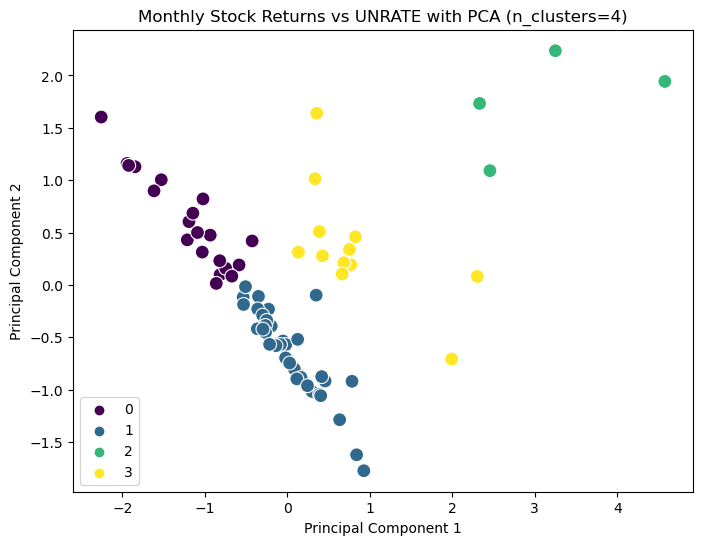

With PCA - UNRATE: n_clusters=4, Silhouette Score: 0.48, Davies-Bouldin Index: 0.73, Calinski-Harabasz Index: 78.83


In [19]:
from src.mykmeans import MyKMeans

kmeans = MyKMeans()
kmeans.set_econ_data()
indicators = ['REAINTRATREARAT10Y', 'MEDCPIM158SFRBCLE', 'PSAVERT', 'UNRATE']
kmeans.economic_indicator_clustering_without_pca(indictors=indicators)
kmeans.economic_indicator_clustering_pca(indictors=indicators)

# ARMIA visualizations

AAPL


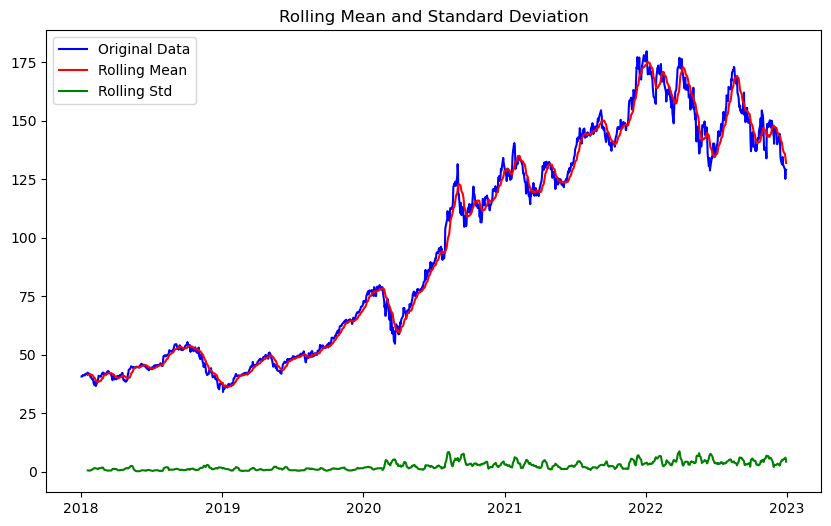

ADF Statistic: -1.0638032652304377
p-value: 0.7292888614630008
Critical Values:
1%: -3.4356048614183443
5%: -2.8638605461891617
10%: -2.5680054872544145
AMD


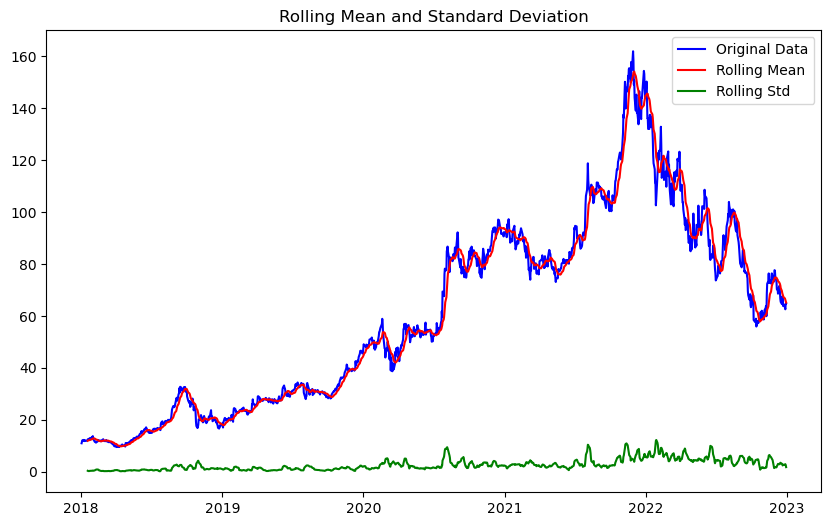

ADF Statistic: -1.512308971876385
p-value: 0.5274137169931019
Critical Values:
1%: -3.4355629707955395
5%: -2.863842063387667
10%: -2.567995644141416
AMZN


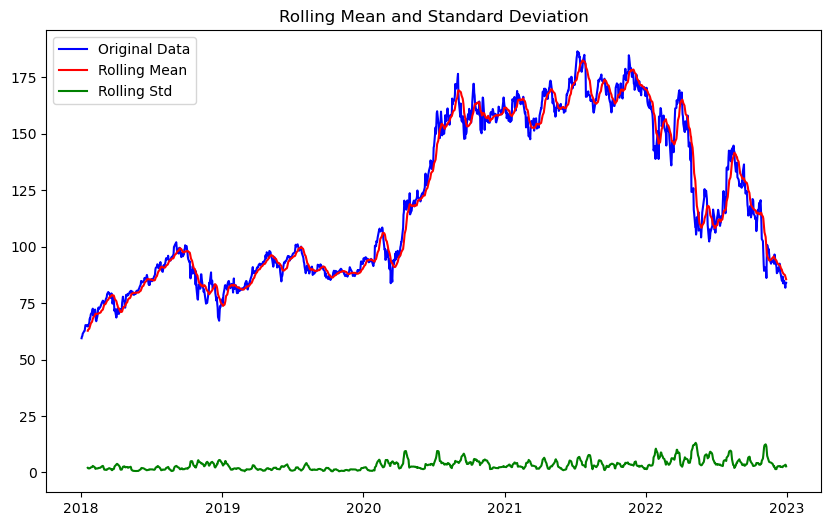

ADF Statistic: -1.7054380039010952
p-value: 0.4283128541618343
Critical Values:
1%: -3.4355588184378574
5%: -2.8638402312881497
10%: -2.5679946684494275
F


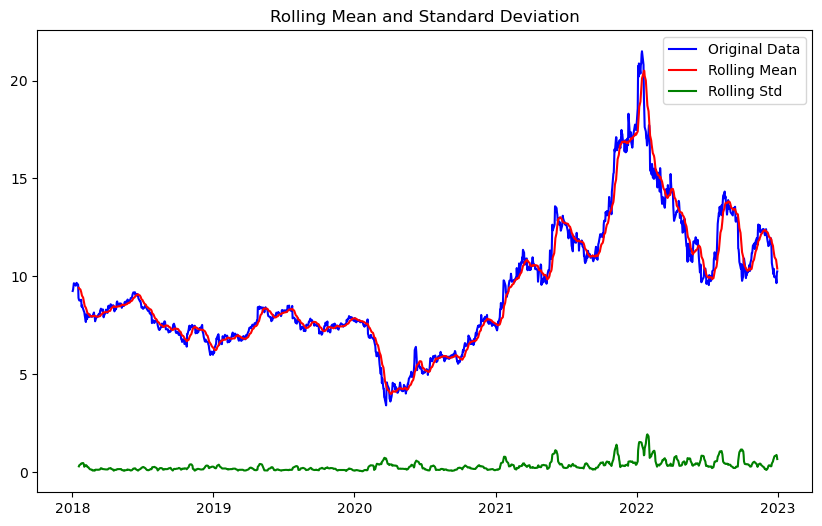

ADF Statistic: -1.438554935444559
p-value: 0.5636592810739032
Critical Values:
1%: -3.4355588184378574
5%: -2.8638402312881497
10%: -2.5679946684494275
GOOG


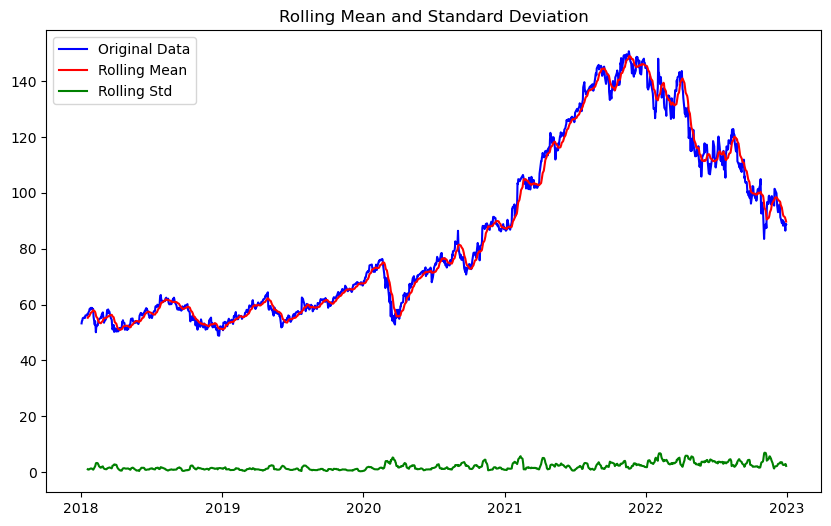

ADF Statistic: -1.210834526787703
p-value: 0.6689176927500178
Critical Values:
1%: -3.4355629707955395
5%: -2.863842063387667
10%: -2.567995644141416
INTC


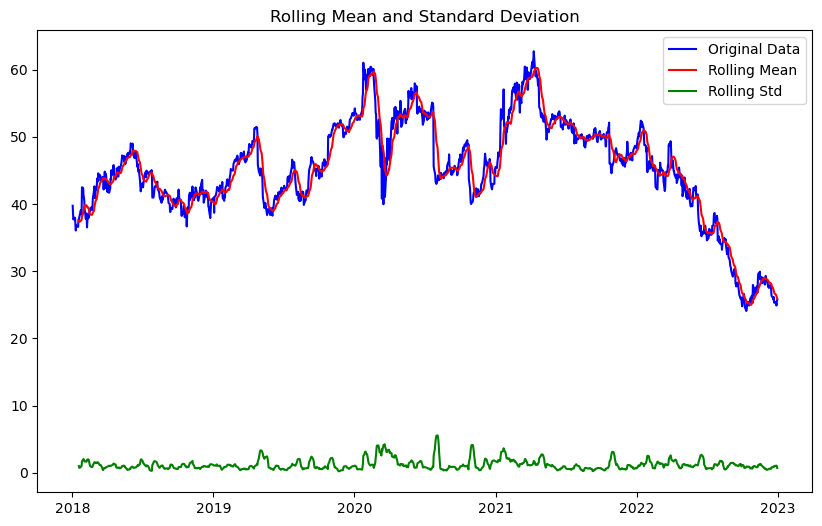

ADF Statistic: -1.693811834122274
p-value: 0.43430359340885405
Critical Values:
1%: -3.4355964295197743
5%: -2.863856825923603
10%: -2.5680035060041626
JPM


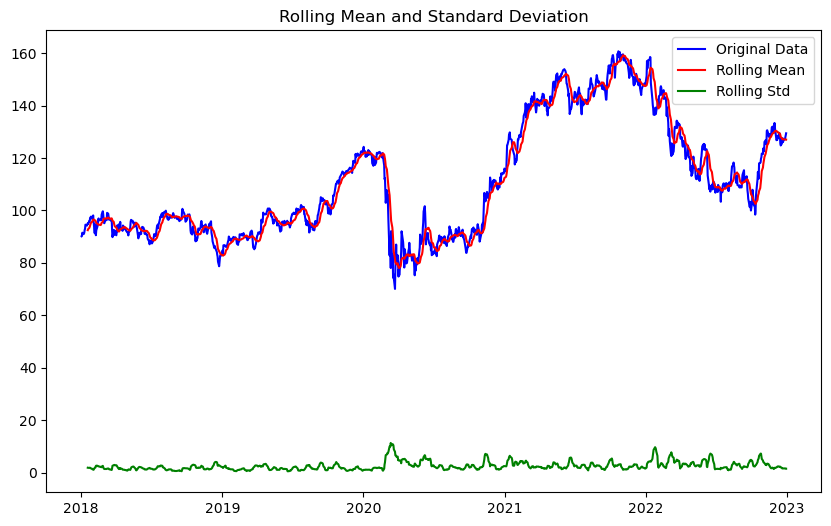

ADF Statistic: -1.4722532485304018
p-value: 0.5471899014440734
Critical Values:
1%: -3.4356133204636095
5%: -2.8638642784217305
10%: -2.5680074748794373
MSFT


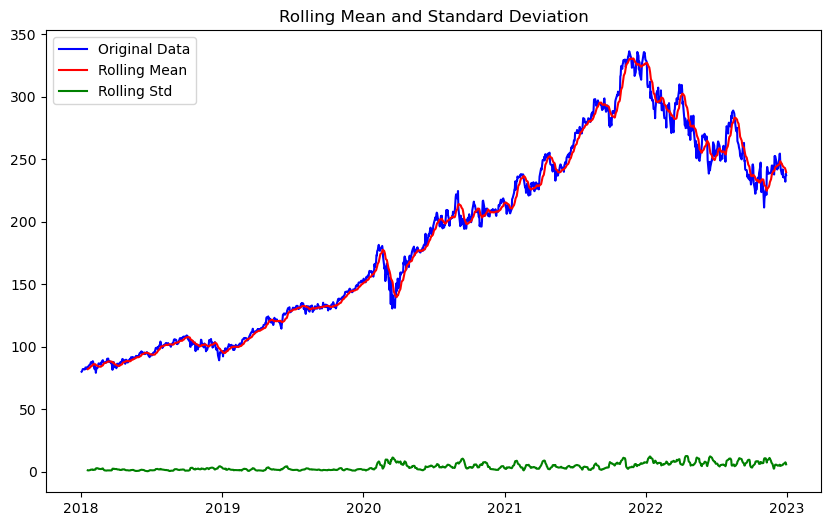

ADF Statistic: -1.2874764129153728
p-value: 0.634882216289284
Critical Values:
1%: -3.4355964295197743
5%: -2.863856825923603
10%: -2.5680035060041626
MS


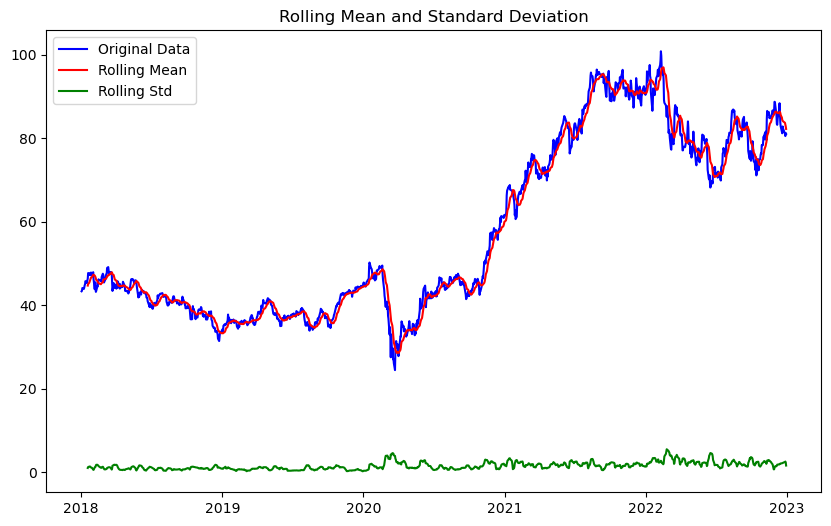

ADF Statistic: -0.743550177594831
p-value: 0.8351443626372537
Critical Values:
1%: -3.435592223709696
5%: -2.8638549702604803
10%: -2.56800251776
NVDA


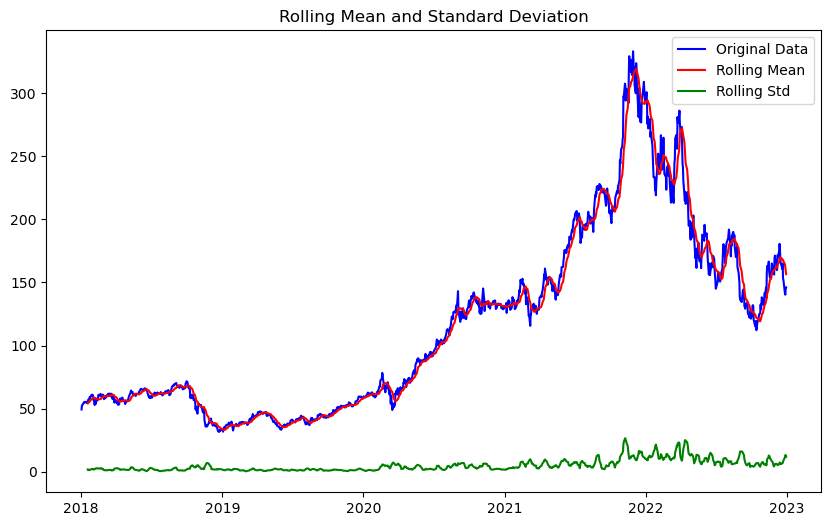

ADF Statistic: -1.188875318599872
p-value: 0.6783628678327054
Critical Values:
1%: -3.435630320520318
5%: -2.863871779019612
10%: -2.56801146937726
TSLA


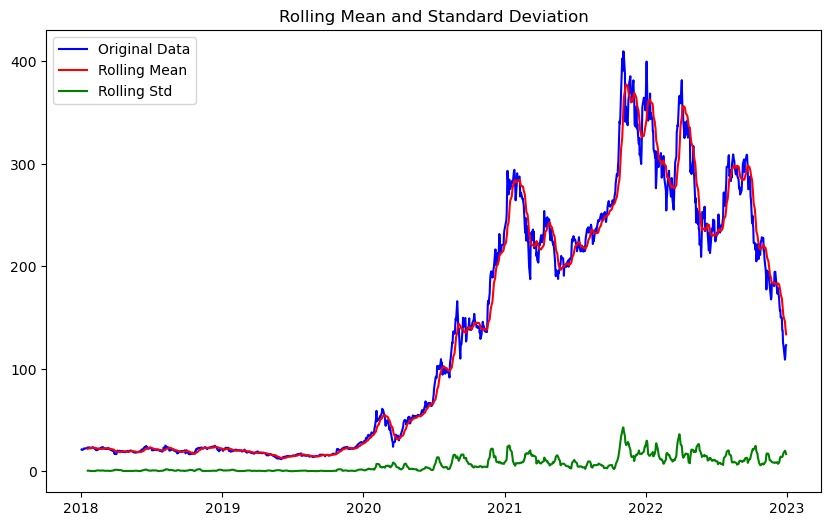

ADF Statistic: -1.301075667011038
p-value: 0.6286800511343598
Critical Values:
1%: -3.435634587707382
5%: -2.8638736617392837
10%: -2.568012472034339
VOO


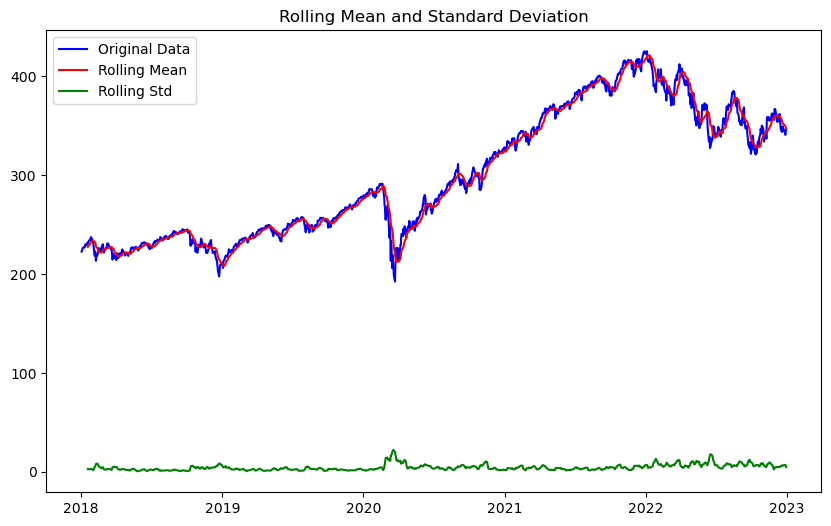

ADF Statistic: -1.1490807366527291
p-value: 0.6951077718585853
Critical Values:
1%: -3.4356006420838963
5%: -2.8638586845641063
10%: -2.5680044958343604


In [20]:
# Check for stationarity using the Augmented Dickey-Fuller test
models = []
for col in train_data.columns:
    print(col)
    adj_closed = train_data[col]
    # columns_except_first = stock_data.iloc[:, 1:]
    arima = MyARIMA(adj_closed)
    models.append((arima,col))
    arima.check_stationarity(adj_closed)

Looking at the Rolling Mean and Original Data, We are deciding whether the time series can be captured by a normal time series or 
it needs to be converted to logarithm

In [21]:
convert_log = {'AAPL' : True,'AMD' : True,'AMZN': False,'F': True,'GOOG' : False,'INTC':False,'JPM':False,'MSFT':False, 'MS': True,
               'NVDA':True, 'TSLA':True,'VOO':False}

The plot depicts increasing mean and standard deviation. Additionally p-value > 0.05. Hence, the timeseries is not stationary.

Additionally, the test statistics exceeds the critical values. As a result, the data is nonlinear.

### Make the time-series stationary

### ACF and PACF plots 

AAPL


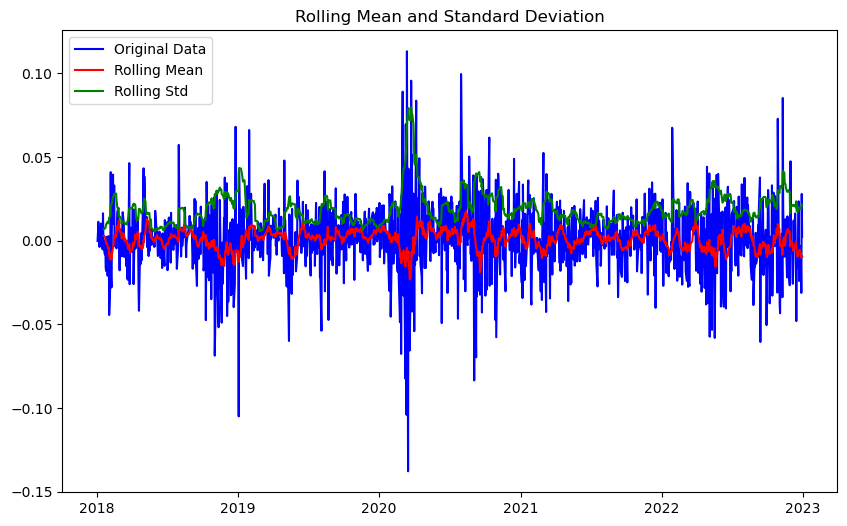

ADF Statistic: -11.071302356820915
p-value: 4.546352997700879e-20
Critical Values:
1%: -3.4355964295197743
5%: -2.863856825923603
10%: -2.5680035060041626


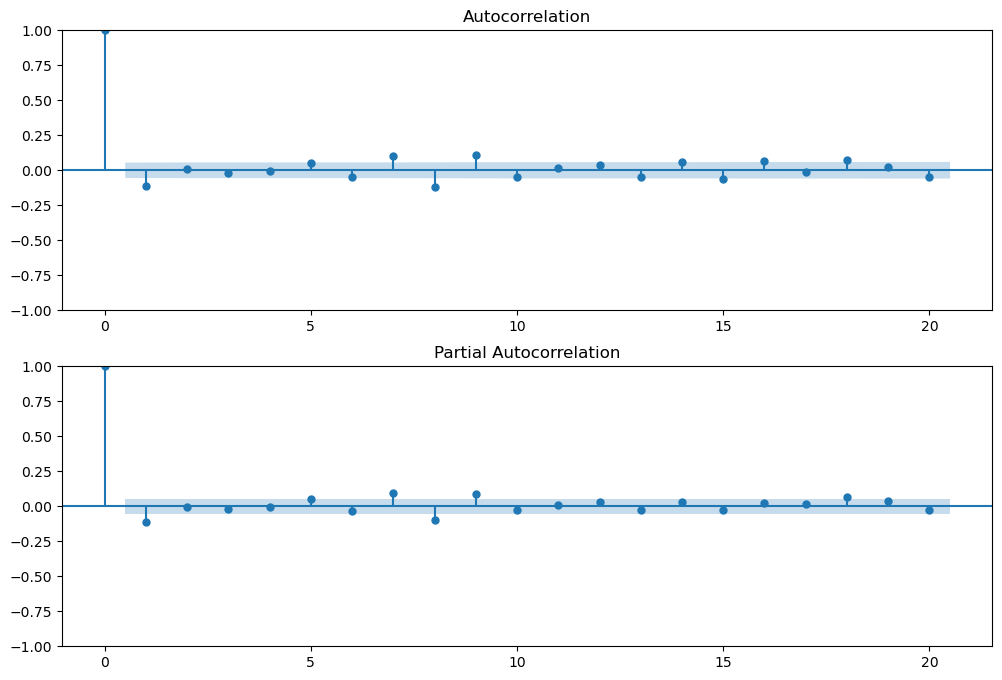

AMD


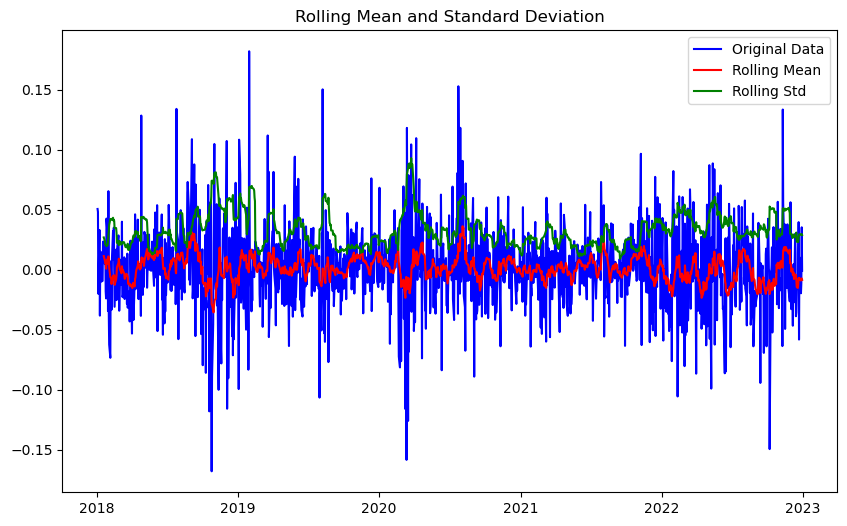

ADF Statistic: -21.30208965431885
p-value: 0.0
Critical Values:
1%: -3.435571295403709
5%: -2.863845736356174
10%: -2.567997600196822


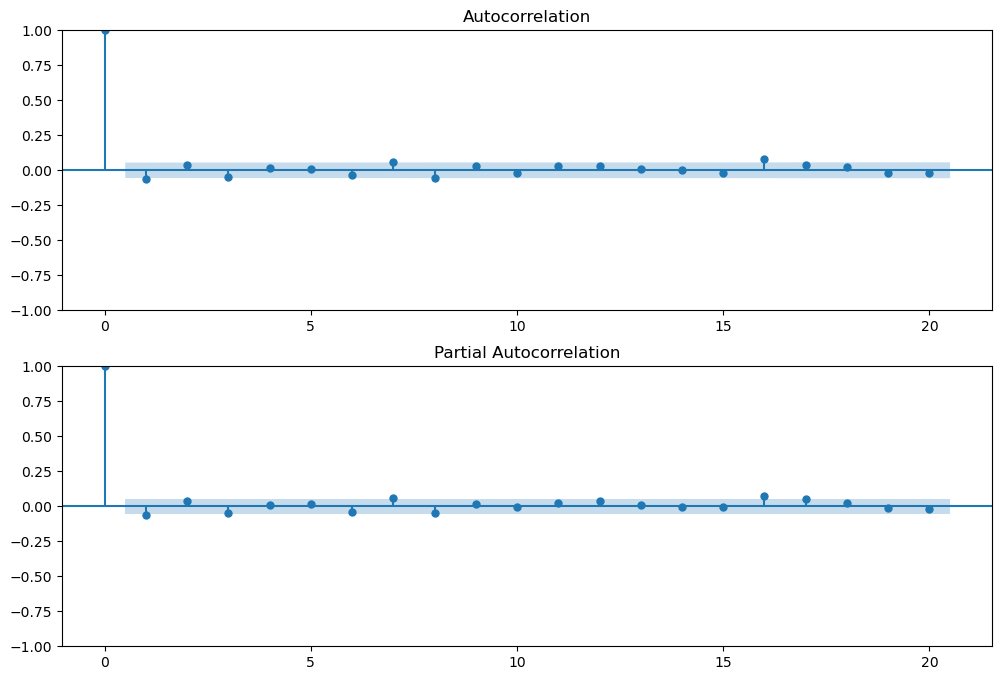

AMZN


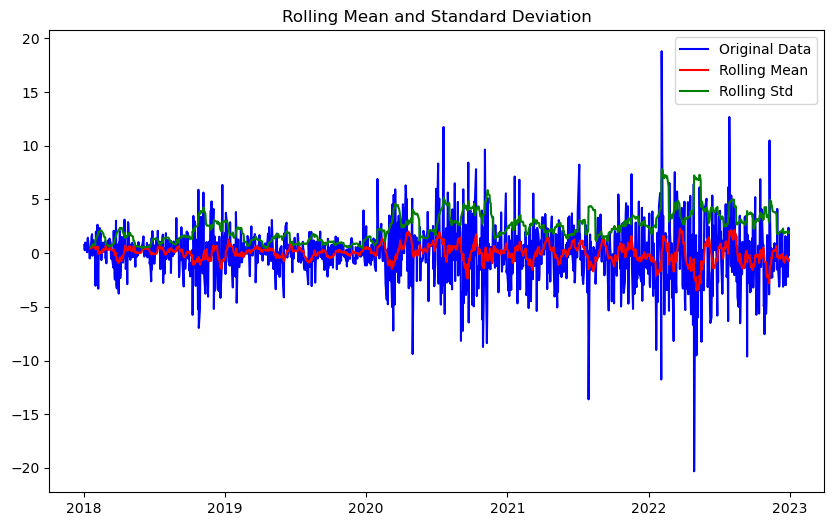

ADF Statistic: -36.13716788912933
p-value: 0.0
Critical Values:
1%: -3.4355629707955395
5%: -2.863842063387667
10%: -2.567995644141416


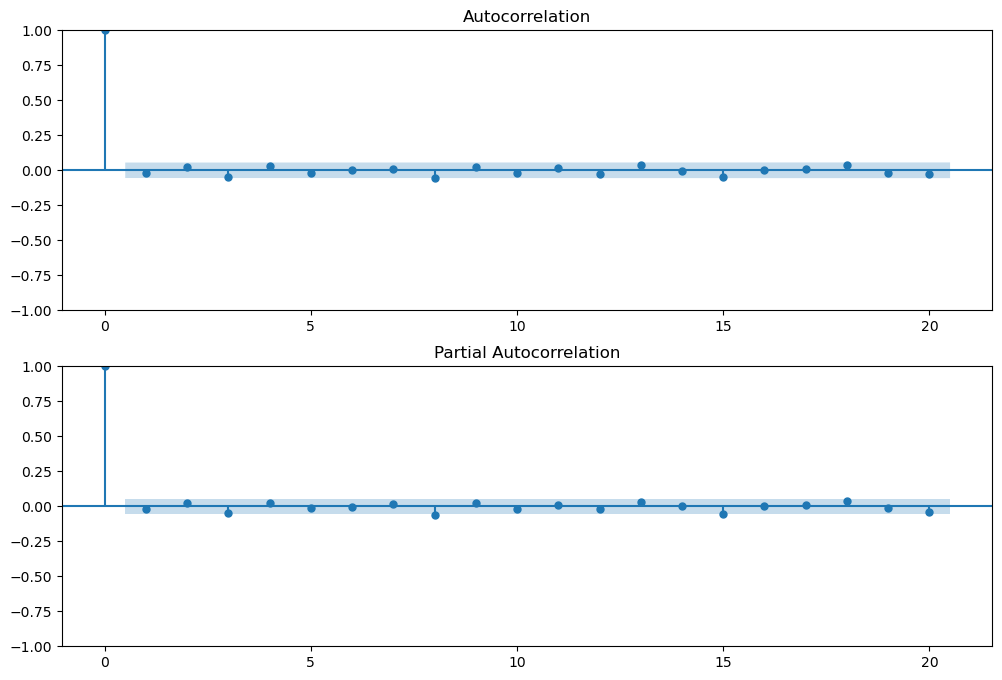

F


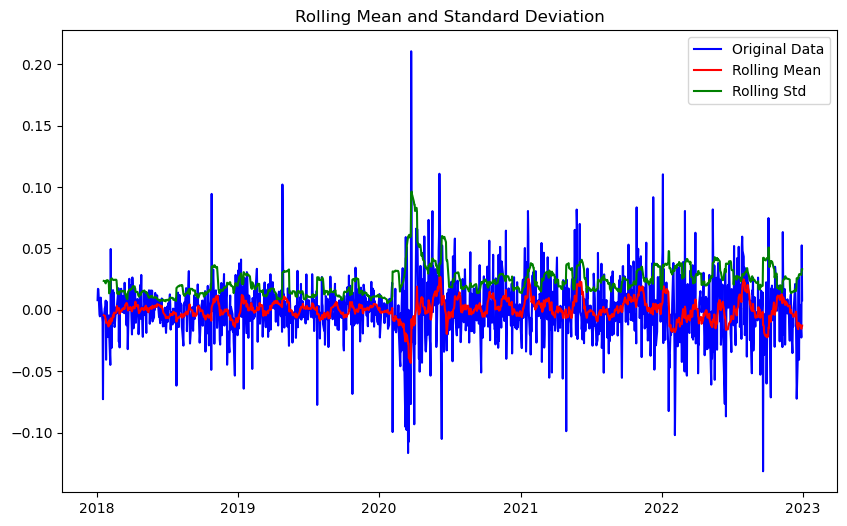

ADF Statistic: -10.888775095221412
p-value: 1.2404053268587279e-19
Critical Values:
1%: -3.4355964295197743
5%: -2.863856825923603
10%: -2.5680035060041626


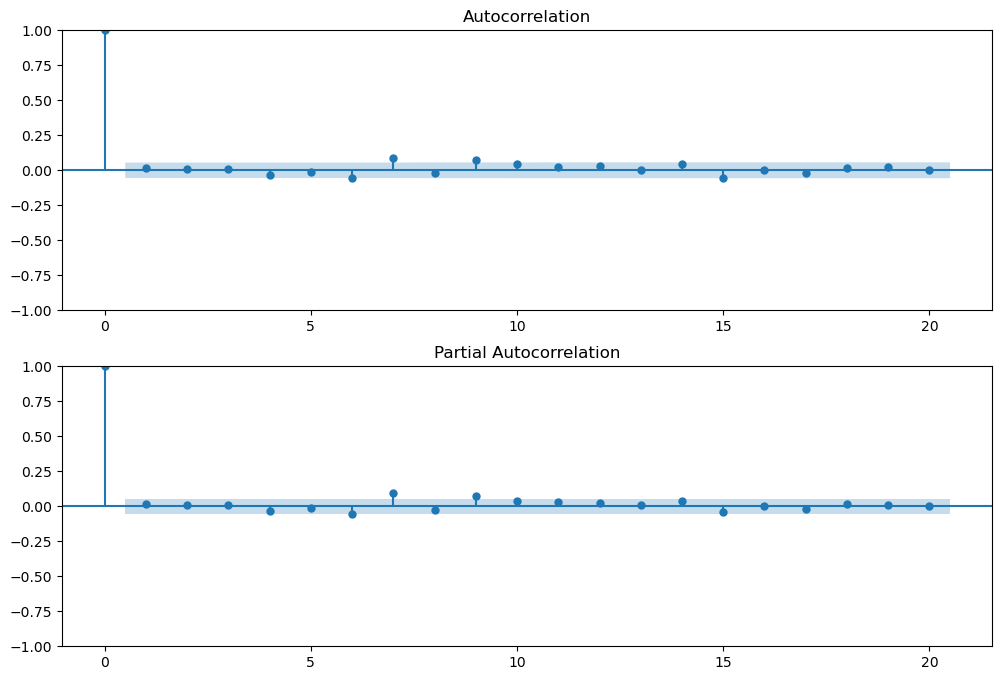

GOOG


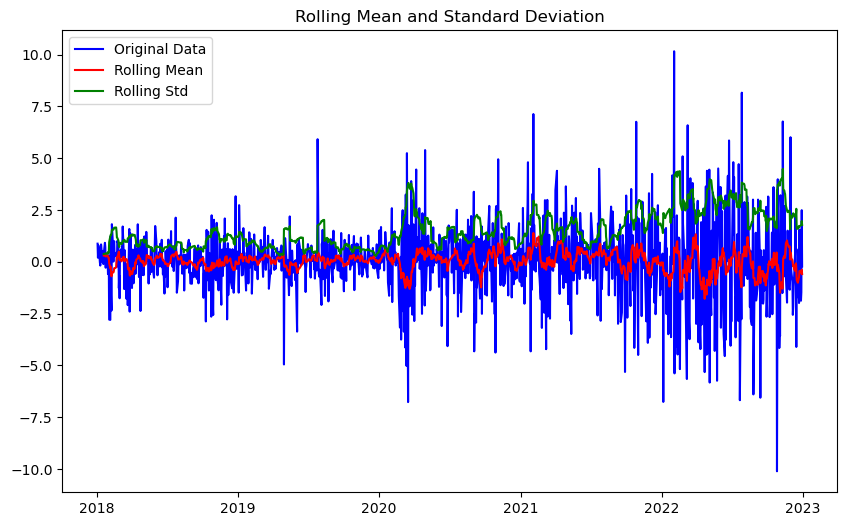

ADF Statistic: -37.739611097324584
p-value: 0.0
Critical Values:
1%: -3.4355629707955395
5%: -2.863842063387667
10%: -2.567995644141416


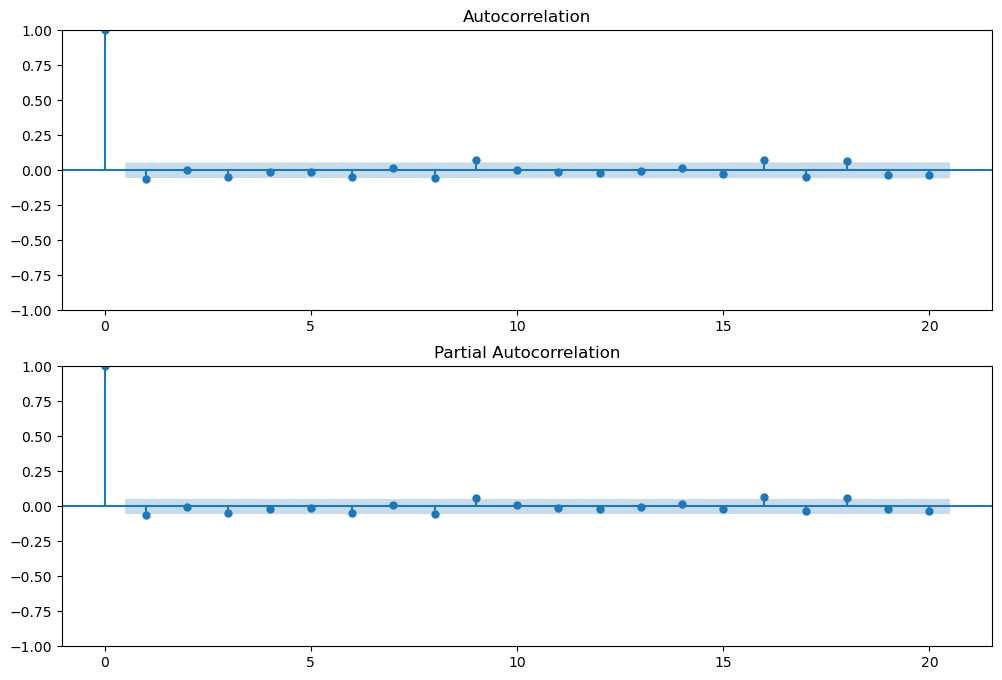

INTC


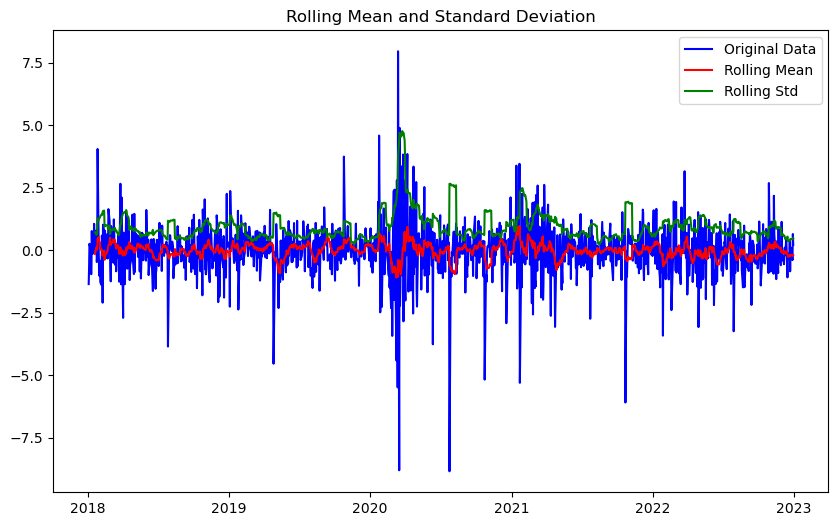

ADF Statistic: -11.73327448489709
p-value: 1.3260038850277394e-21
Critical Values:
1%: -3.4355964295197743
5%: -2.863856825923603
10%: -2.5680035060041626


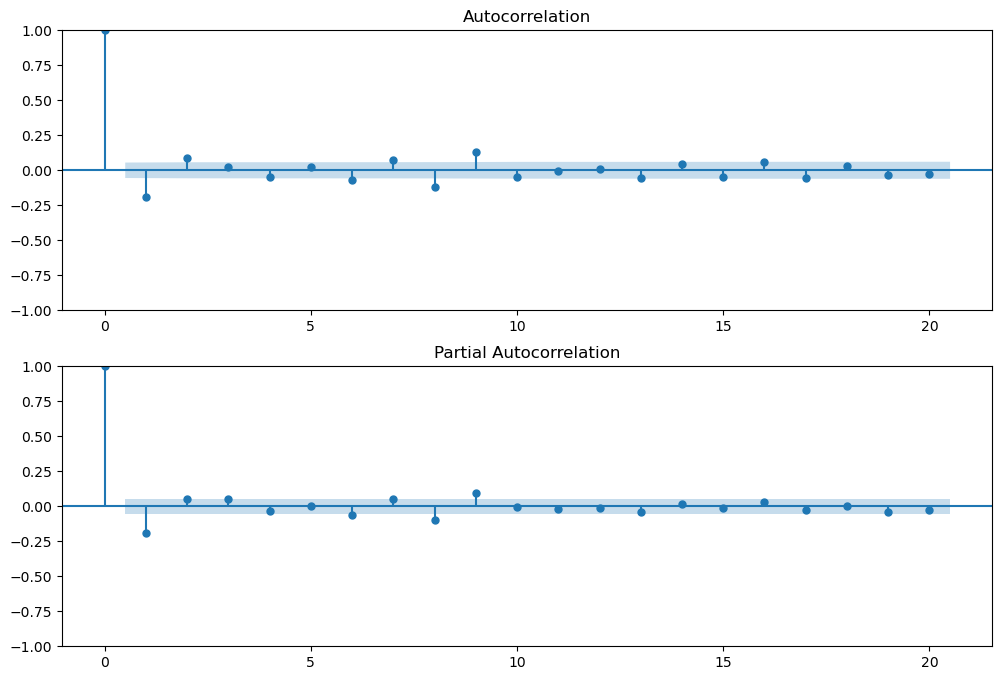

JPM


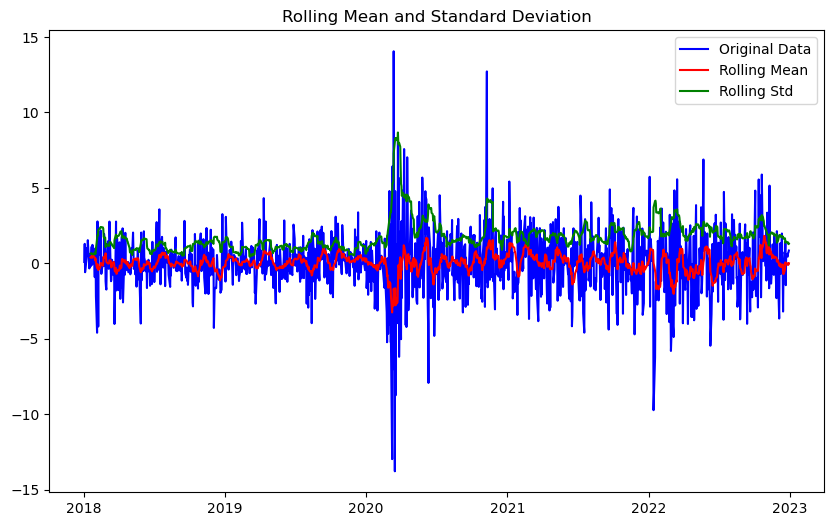

ADF Statistic: -10.612216706206885
p-value: 5.794739398928595e-19
Critical Values:
1%: -3.4356133204636095
5%: -2.8638642784217305
10%: -2.5680074748794373


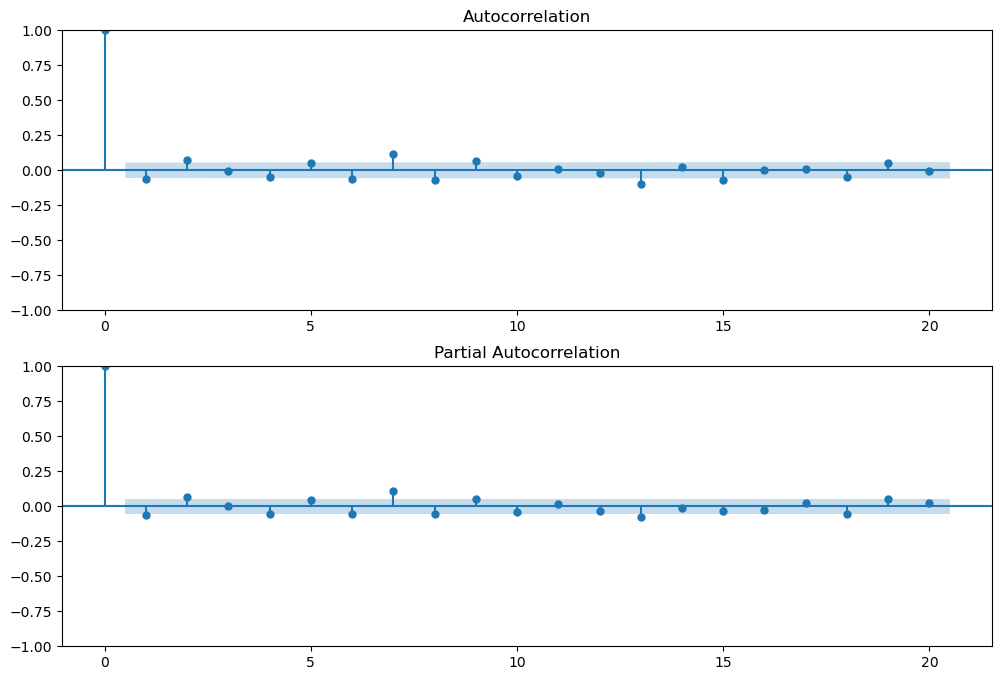

MSFT


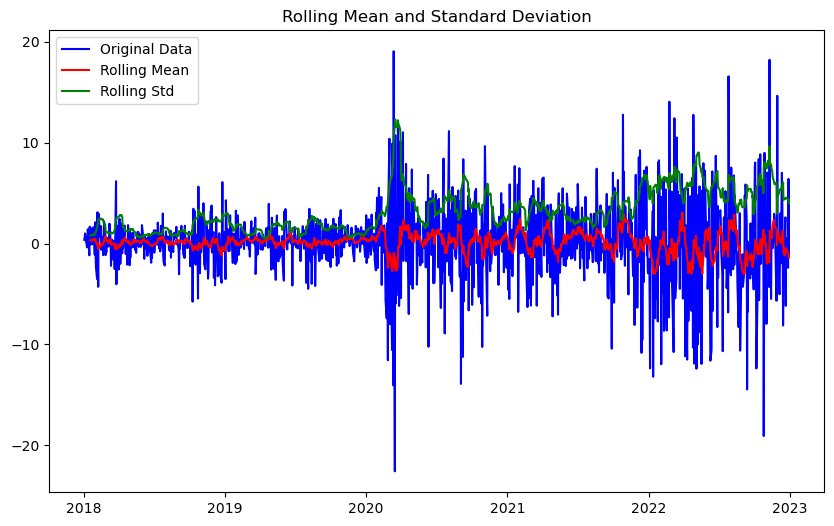

ADF Statistic: -11.98444714056111
p-value: 3.6406990866817486e-22
Critical Values:
1%: -3.4355964295197743
5%: -2.863856825923603
10%: -2.5680035060041626


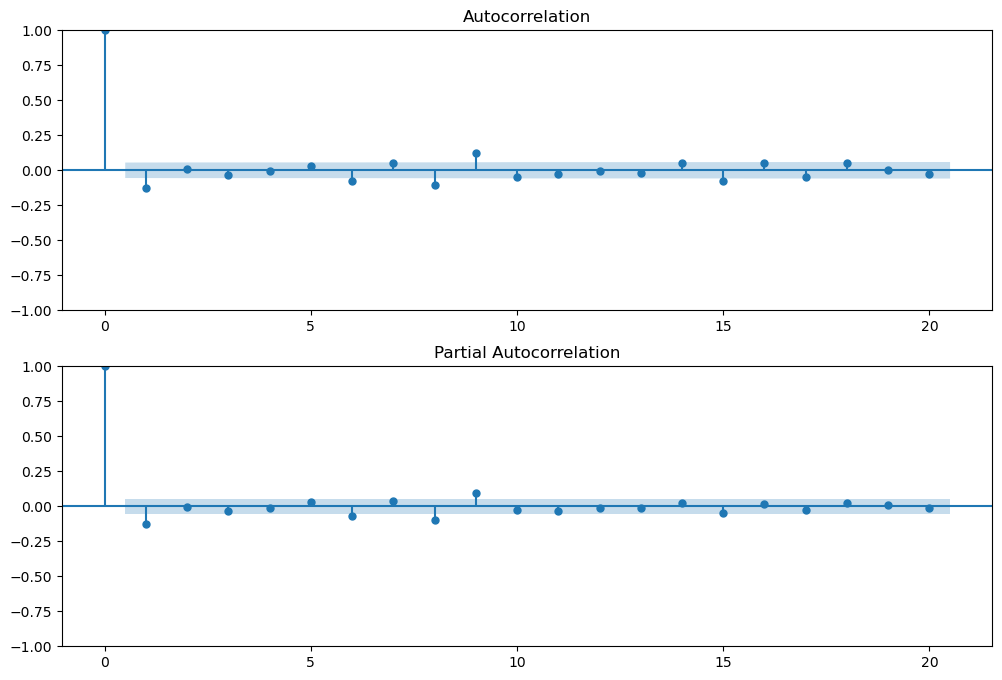

MS


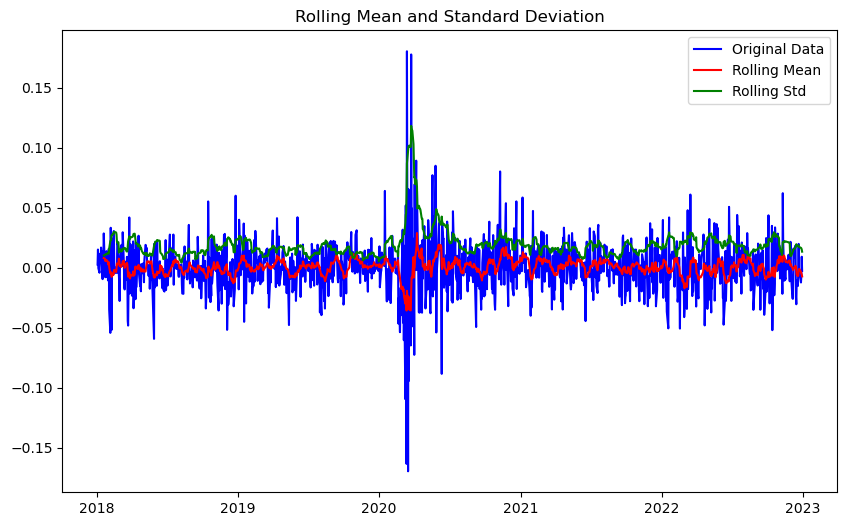

ADF Statistic: -10.83781459412424
p-value: 1.6448853243547561e-19
Critical Values:
1%: -3.4355964295197743
5%: -2.863856825923603
10%: -2.5680035060041626


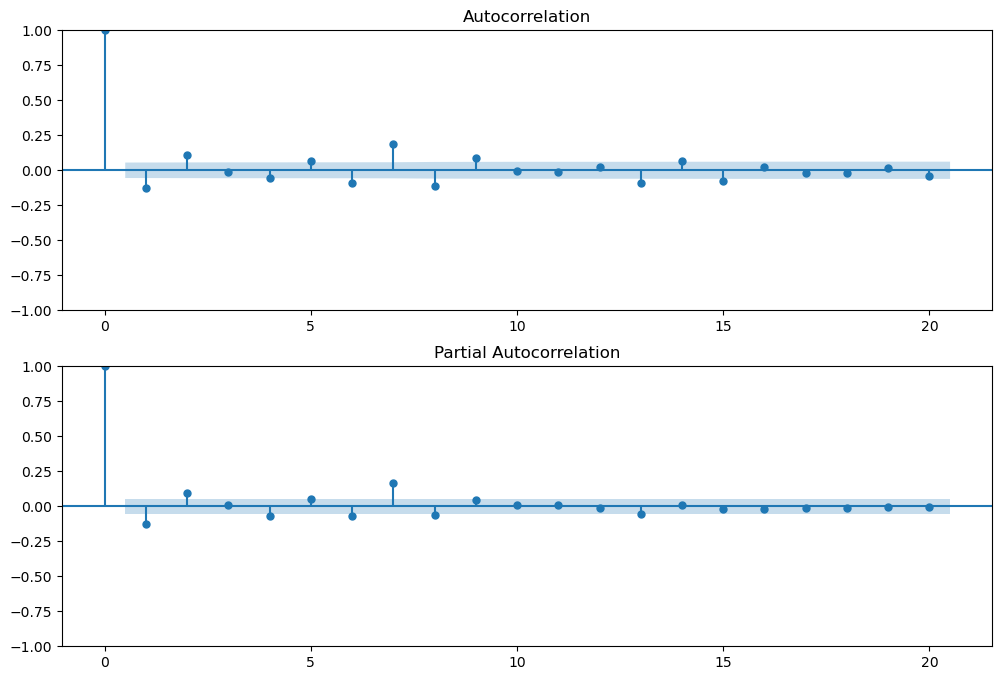

NVDA


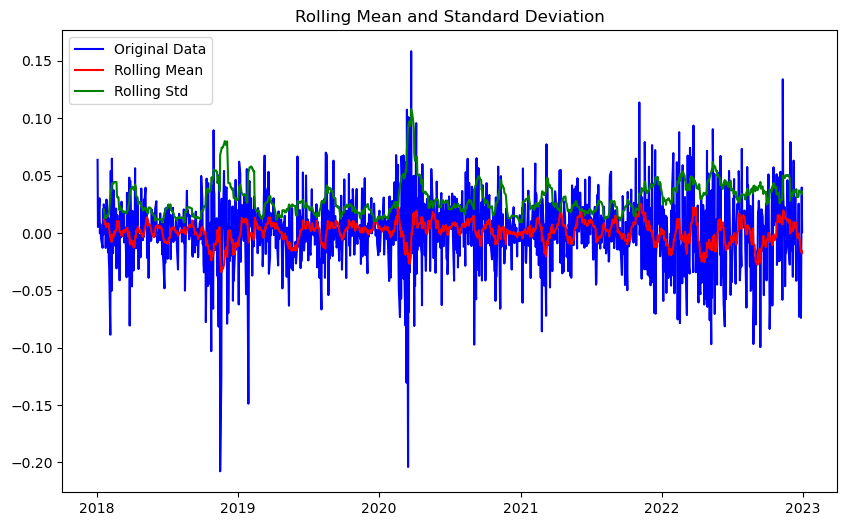

ADF Statistic: -11.585536043262222
p-value: 2.873648731176488e-21
Critical Values:
1%: -3.4355964295197743
5%: -2.863856825923603
10%: -2.5680035060041626


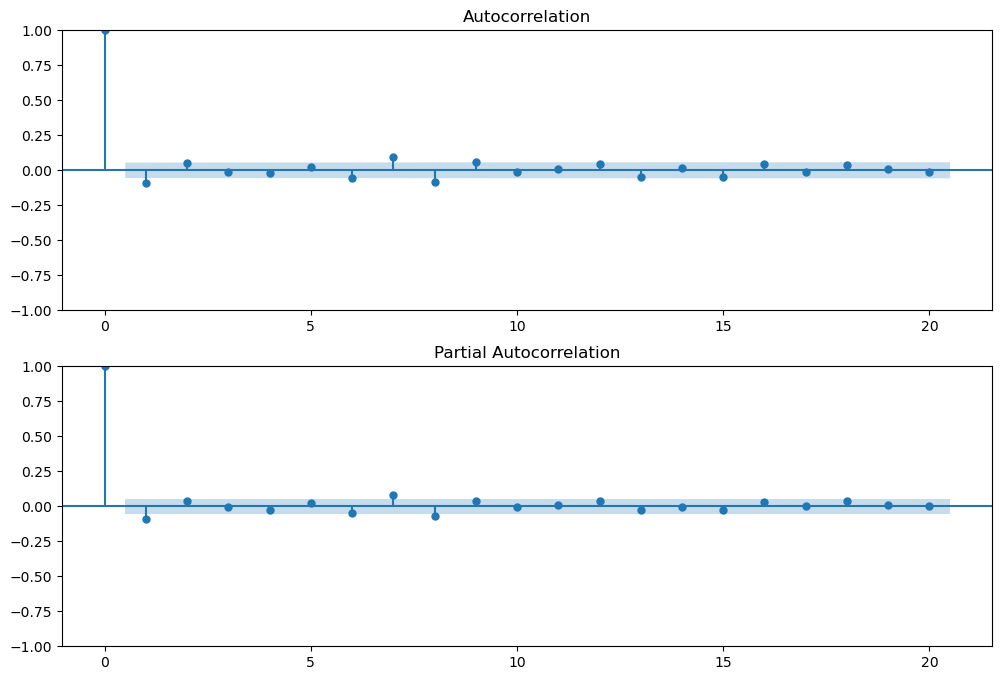

TSLA


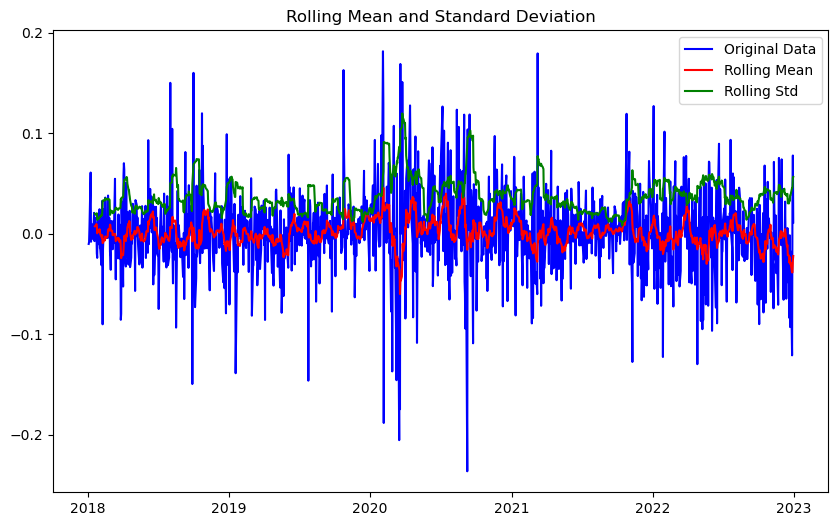

ADF Statistic: -24.148350343702177
p-value: 0.0
Critical Values:
1%: -3.4355671297788666
5%: -2.8638438984080117
10%: -2.5679966213893057


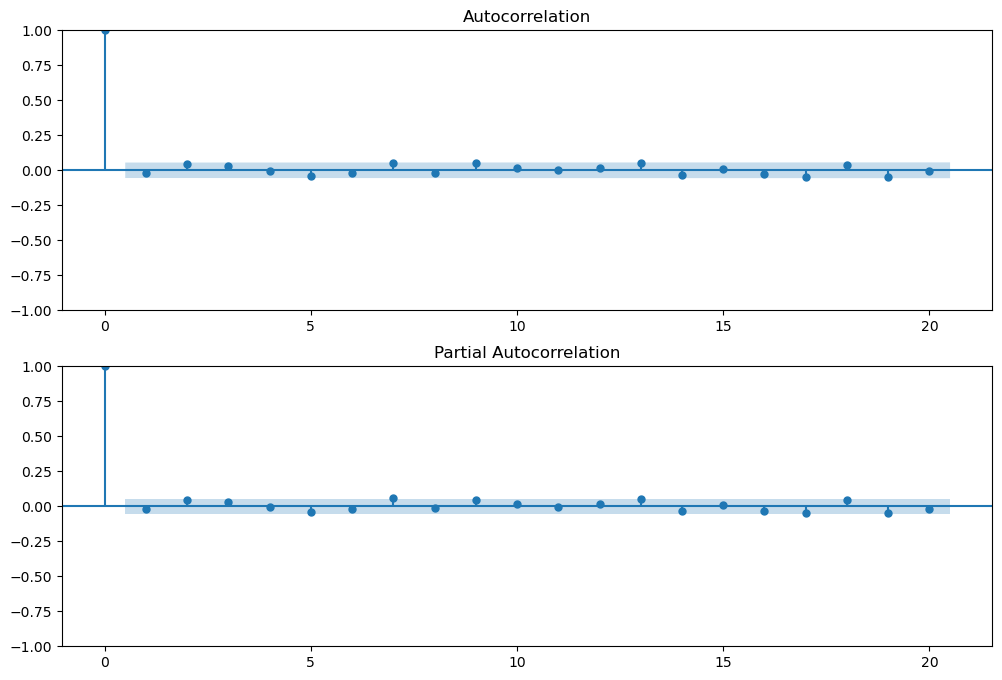

VOO


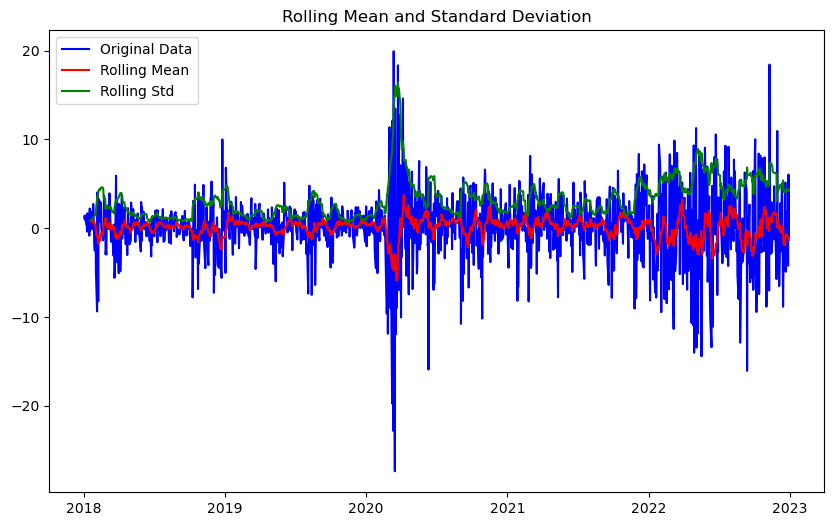

ADF Statistic: -11.03199791560427
p-value: 5.637734930279371e-20
Critical Values:
1%: -3.4356006420838963
5%: -2.8638586845641063
10%: -2.5680044958343604


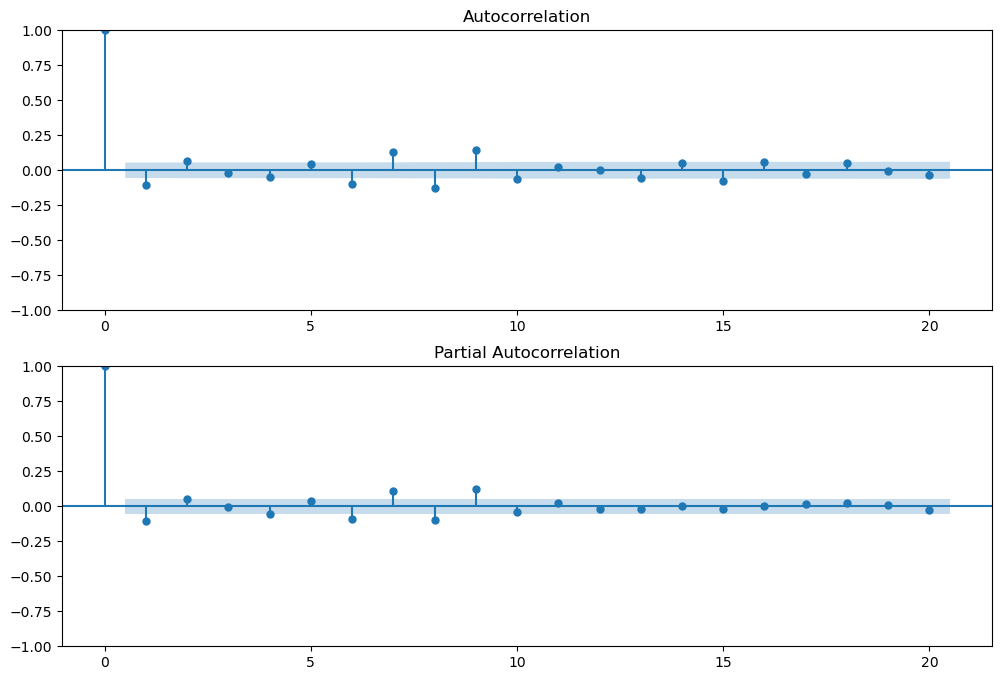

In [22]:
shift = 1
for arima,col in models:
    print(col)
    data = arima.time_series_data
    if convert_log[col]:
        data = arima.log_data(data)
    diff_data = arima.difference_data(data,shift)[1:]
    arima.check_stationarity(diff_data)
    arima.acf_pacf_plots(diff_data)

All p-values are well below the threshold, so we can consider the difference time series to be stationary. So the degree d of ARIMA(p,d,q) for all stocks is 1.

For p and q values, we will use the auto arima function to get the parameters for the ARIMA model

In [23]:
forecasted_data = test_data.copy()
N = len(forecasted_data)
for arima,col in models:
    print(col)
    data = arima.time_series_data
    if convert_log[col]:
        data = arima.log_data(data)
    arima.fit_arima_parameters(data)
    if convert_log[col]:
        forecasted_data[col] = np.exp(arima.forecast(data,N))
    else:
        forecasted_data[col] = arima.forecast(data,N)


AAPL


/Users/kaushikarcot/anaconda3/envs/ml_portfolio_opt/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AMD


/Users/kaushikarcot/anaconda3/envs/ml_portfolio_opt/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AMZN
F
GOOG
INTC
JPM
MSFT
MS
NVDA
TSLA
VOO


In [24]:
mpt = MPTOptimizer()

In [25]:
arima_allocs = mpt.optimize_portfolio(forecasted_data)
print([round(val,3) for val in arima_allocs])

[0.0, 0.0, 0.0, 0.0, 0.946, 0.0, 0.0, 0.0, 0.013, 0.041, 0.0, 0.0]


In [26]:
mpt_allocs = mpt.optimize_portfolio(train_data)
print([round(val,3) for val in mpt_allocs])

[0.0, 0.575, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.425, 0.0]


In [27]:
mean_arima, std_arima, cr_arima, sr_arima = utils.sharpe_ratio_metrics(test_data,arima_allocs)
print(mean_arima, std_arima,cr_arima, sr_arima)

0.0022795553922053 0.018683355787078724 0.6882696373803454 1.93684798479595


In [28]:
mean_mpt, std_mpt,cr_mpt, sr_mpt = utils.sharpe_ratio_metrics(test_data,mpt_allocs)
print(mean_mpt, std_mpt,cr_mpt, sr_mpt)

0.003703578123647948 0.02666531118717098 1.3003698374769281 2.204830074734548


In [29]:
treynor_arima,beta_arima,alpha_arima = utils.treynor_ratio_metrics(test_data,arima_allocs,index_data)
print(treynor_arima,beta_arima,alpha_arima)

0.0014108051312231586 1.4775643680839206 0.0008241597739148897


In [30]:
treynor_mpt,beta_mpt,alpha_mpt = utils.treynor_ratio_metrics(test_data,mpt_allocs,index_data)
print(treynor_mpt,beta_mpt,alpha_mpt)

0.0016682319022800077 2.1031716986425564 0.0016319615221416749
